# Parcial Punto 2

Este Jupyter Book resume los modelos estadisticos solicitados para las diferentes ventanas de tiempo de predición para la serie de tiempo Bitcoin Price. Los modelos de Garch serán revisados con la serie de tiempo de volatilidad, pues este es uso.

## LIBRERIAS Y FUNCIONES

### Librerias

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import plotly.express as px
from statsmodels.tsa import stattools
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as stats
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import itertools
from tqdm import tqdm  # Para mostrar una barra de progreso
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import Holt
from statsmodels.graphics.tsaplots import plot_predict, plot_acf

#Formato y colores
from IPython.display import display, HTML

ModuleNotFoundError: No module named 'plotly'

### Accuracy

In [422]:
def forecast_accuracy(forecast, actual, str_name, str_model, lj_lags = [10], window_str = ''):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))    # MAPE
    mae = np.mean(np.abs(forecast - actual))                      # MAE
    mse = np.mean((forecast - actual) ** 2)                       # MSE
    rmse = np.sqrt(mse)                                           # RMSE

    # Cálculo del R²
    ss_res = np.sum((actual - forecast) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Cálculo de los residuales
    residuals = actual - forecast

    # Prueba de Ljung-Box
    lb_test = acorr_ljungbox(residuals, lags=lj_lags, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[-1]  # p-valor en el lag máximo especificado (10 en este caso)

    # Prueba de Jarque-Bera
    jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residuals)

    df_acc = pd.DataFrame({
        'model': str_model,
        'window': window_str,
        'MAE': [mae],
        'MSE': [mse],
        'MAPE': [mape],
        'RMSE': [rmse],
        'R2': [r2],
        'Ljung-Box p-value': [lb_pvalue],
        'Jarque-Bera p-value': [jb_pvalue]
    }, index=[str_name])

    return df_acc





### Residuos - Independencia y normalidad

In [423]:
""" def independence_normality(residuals, nlags_ljbox):
  print('----- Test de Independencia  Ljung-Box --------')
  
  #Ho: no hay autocorrelación en los residuos
  acf_, confint_, qstat_, pvalues_ = stattools.acf(residuals, nlags=nlags_ljbox, qstat=True,alpha=0.05)
  alpha = 0.05
  
  for l, p_val in enumerate(pvalues_):
      if p_val > alpha:
          print('Null hypothesis is accepted at lag = {} for p-val = {}'.format(l, p_val))
      else:
          print('Null hypothesis is rejected at lag = {} for p-val = {}'.format(l, p_val))
  
  print('----- Test de Normalidad  Jarque-Bera --------')

  #jarque bera
  #Ho= los residuos tienen distribuci´on normal
  JB, JBpv, skew, kurtosis = jarque_bera(residuals)

  if JBpv > alpha:
        print('Null hypothesis is accepted, residuos normales')
  else:
        print('Null hypothesis is rejected, residuos no normales' )

  print('----- Grafico de serie de residuos --------')
  fig = px.line(residuals, 
               #x=fechas, 
                #y='residuos', 
                title='Serie Temporal de los Residuos', 
                labels={'fecha': 'Fecha', 'residuos': 'Residuos'})
  fig.show()

  print('----- QQ Plot --------')

  #Valores teoricos
  qq = stats.probplot(residuals, dist="norm")
  # Los valores observados y teóricos
  teoricos = qq[0][0]  # Cuantiles teóricos
  observados = qq[0][1]  # Cuantiles observados (residuos)
  # Crear el DataFrame para el Q-Q plot
  qq_plot_df = pd.DataFrame({'Teóricos': teoricos, 'Observados': observados})
  # Crear el Q-Q plot con Plotly Express
  fig = px.scatter(qq_plot_df, 
                 x='Teóricos', 
                 y='Observados', 
                 title='Q-Q Plot de los Residuos')

# Agregar la línea de referencia (y=x)
  fig.add_shape(type='line',
              x0=min(teoricos), y0=min(teoricos),
              x1=max(teoricos), y1=max(teoricos),
              line=dict(color='firebrick', dash='dash'))

# Mostrar el gráfico
  fig.show()

  print('----- ACF de Residuos --------')

  fig = plt.figure(figsize=(5.5, 5.5))
  ax = fig.add_subplot(1,1,1)
  ax.set_title('ACF of Residuals')
  autocorrelation_plot(residuals, color='b', ax = ax)
  fig.show() """

def independence_normality(residuals, nlags_ljbox):
    print('----- Test de Independencia  Ljung-Box --------')
  
    # Ho: no hay autocorrelación en los residuos
    acf_, confint_, qstat_, pvalues_ = stattools.acf(residuals, nlags=nlags_ljbox, qstat=True, alpha=0.05)
    alpha = 0.05
  
    for l, p_val in enumerate(pvalues_):
        if p_val > alpha:
            print('Null hypothesis is accepted at lag = {} for p-val = {}'.format(l, p_val))
        else:
            print('Null hypothesis is rejected at lag = {} for p-val = {}'.format(l, p_val))
  
    print('----- Test de Normalidad  Jarque-Bera --------')

    # Jarque-Bera
    # Ho: los residuos tienen distribución normal
    JB, JBpv, skew, kurtosis = jarque_bera(residuals)

    if JBpv > alpha:
        print('Null hypothesis is accepted, residuos normales')
    else:
        print('Null hypothesis is rejected, residuos no normales')

    # Gráfico de la serie temporal de los residuos
    print('----- Grafico de serie de residuos --------')
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuos')
    plt.title('Serie Temporal de los Residuos')
    plt.xlabel('Fecha')
    plt.ylabel('Residuos')
    plt.legend()
    plt.show()

    # Q-Q Plot
    print('----- QQ Plot --------')
    qq = stats.probplot(residuals, dist="norm")
    teoricos = qq[0][0]  # Cuantiles teóricos
    observados = qq[0][1]  # Cuantiles observados (residuos)

    plt.figure(figsize=(10, 6))
    plt.scatter(teoricos, observados, label='Observados')
    plt.plot(teoricos, teoricos, color='firebrick', linestyle='--', label='Línea de referencia')
    plt.title('Q-Q Plot de los Residuos')
    plt.xlabel('Teóricos')
    plt.ylabel('Observados')
    plt.legend()
    plt.show()

    print('----- ACF de Residuos --------')
    fig = plt.figure(figsize=(5.5, 5.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('ACF of Residuals')
    autocorrelation_plot(residuals, color='b', ax=ax)
    plt.show()  # Asegura que se renderice al instante




### Grafica Train, Val. y Test

In [424]:
def plot_model(train, val, test, y_pred, title):
    import pandas as pd
    import plotly.express as px
    from sklearn.metrics import mean_absolute_error

    # Prepare the data
    train_df = pd.DataFrame({
        'Time': train[-300:].index,
        'Value': train[-300:].values,
        'Category': 'Train'
    })
    val_df = pd.DataFrame({
        'Time': val.index,
        'Value': val.values,
        'Category': 'Validation'
    })
    test_df = pd.DataFrame({
        'Time': test.index,
        'Value': test.values,
        'Category': 'Test'
    })
    y_pred_df = pd.DataFrame({
        'Time': y_pred.index,
        'Value': y_pred.values,
        'Category': 'Prediction'
    })

    # Combine the data
    df = pd.concat([train_df, val_df, test_df, y_pred_df], axis=0)

    # Add line dash style
    df['Dash'] = df['Category'].map({
        'Train': 'solid',
        'Validation': 'solid',
        'Test': 'solid',
        'Prediction': 'dash'
    })

    # Compute MAE
    mae = mean_absolute_error(test, y_pred)

    # Plot using Plotly Express
    fig = px.line(
        df,
        x='Time',
        y='Value',
        color='Category',
        line_dash='Dash',
        title=f"{title}, MAE: {round(mae, 2)}",
        color_discrete_map={
            'Train': 'blue',
            'Validation': 'orange',
            'Test': 'green',
            'Prediction': 'red'
        }
    )

    fig.update_layout(
        xaxis_title='Time',
        yaxis_title='Value',
        legend_title='',
        template='plotly_white'
    )

    fig.show()

### FX - Train, Val. y Test

In [425]:
def train_val_test(df, window):
  size = len(df)
  train_len = size - 56 # El profesor indicó que este siempre era el tamano del training (28+28)
  val_set_end = train_len + window
  test_set_end = val_set_end + window
  

  train_set = df[:train_len]
  val_set = df[train_len: val_set_end]
  test_set = df[val_set_end: test_set_end]

  return train_set, val_set, test_set

## DATOS

In [426]:
# Data Original
data_init = pd.read_csv('https://raw.githubusercontent.com/lihkir/Data/refs/heads/main/Bitcoin%20Historical%20Data.csv', sep=',')
# Se crea una copia de la data para manipulación
df = data_init.copy(deep= True)

# Solo nos quedamos con las columnas Date y Price
df = df[['Date', 'Price']]

# Se elimina las comas de Price para poder convertirlo a números
df['Price'] = df['Price'].str.replace(',','')

#Convertimos las columnas price en números y date en fecha
df['Price'] = pd.to_numeric(df['Price'])
df['Date'] = pd.to_datetime(df['Date'])

# Se hace que el indice sea la columna Date
df.index = df['Date']
df.drop('Date', axis=1, inplace=True)

df = df.sort_index(ascending= True)
df_copy = df.copy(deep= True)
df.reset_index(drop=True, inplace=True)

timeserie = df["Price"]

px.line(df, x= df.index,  y = df['Price'])

In [427]:
df.describe()

Price
count   4999.000000
mean   10812.283337
std    15892.032468
min        0.100000
25%      226.700000
50%     1975.100000
75%    15450.150000
max    73066.300000

## MODELOS

In [428]:
#entanas para el set de validacion y test
windows = [7,14,21,28]
model_summary  = pd.DataFrame()

### SIMPLE EXPONENCIAL SMOOTHING (IMPLEMENTACIÓN SIN LIBRERIA) - BITCOIN PRICE

In [429]:
# Función de Suavizado Exponencial Simple (SES) con verificación de datos
def firstsmooth(y, alpha, start=None):
    if len(y) == 0:
        raise ValueError("La serie de entrenamiento está vacía.")
        
    ytilde = y.copy()
    if start is None:
        start = y.iloc[0]
    ytilde.iloc[0] = alpha * y.iloc[0] + (1 - alpha) * start
    for i in range(1, len(y)):
        ytilde.iloc[i] = alpha * y.iloc[i] + (1 - alpha) * ytilde.iloc[i - 1]
    return ytilde

# Función para generar predicciones basadas en el último valor suavizado
def ses_forecast(train, val_length, alpha, start=None):
    # Aplicar SES al conjunto de entrenamiento
    ytilde = firstsmooth(train, alpha, start)
    if len(ytilde) == 0:
        raise ValueError("La serie suavizada está vacía.")
        
    last_smoothed = ytilde.iloc[-1]
    # Generar predicciones para el conjunto de validación
    y_pred = [last_smoothed] * val_length
    return y_pred

# Optimizador SES con verificación de datos
def ses_optimizer(train, val, alphas):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        y_pred = ses_forecast(train, len(val), alpha)
        mae = mean_absolute_error(val, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    return best_alpha, best_mae

# Tuning del modelo
def ses_model_tuning(train, val):
    alphas = [round(a, 2) for a in list(np.arange(0.2, 1, 0.2))]
    best_alpha, best_mae = ses_optimizer(train, val, alphas)
    return best_alpha

#### Entrenamiento

In [430]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha = ses_model_tuning(train, val)
    best_params.append({'window': window, 'alpha': best_alpha})

In [431]:
best_params

[{'window': 7, 'alpha': 0.8},
 {'window': 14, 'alpha': 0.8},
 {'window': 21, 'alpha': 0.8},
 {'window': 28, 'alpha': 0.8}]

      model  window           MAE           MSE        MAPE          RMSE  \
train   SSE       7  32900.611982  1.236833e+09  13411.5969  35168.642882   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
train -4.377388                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos

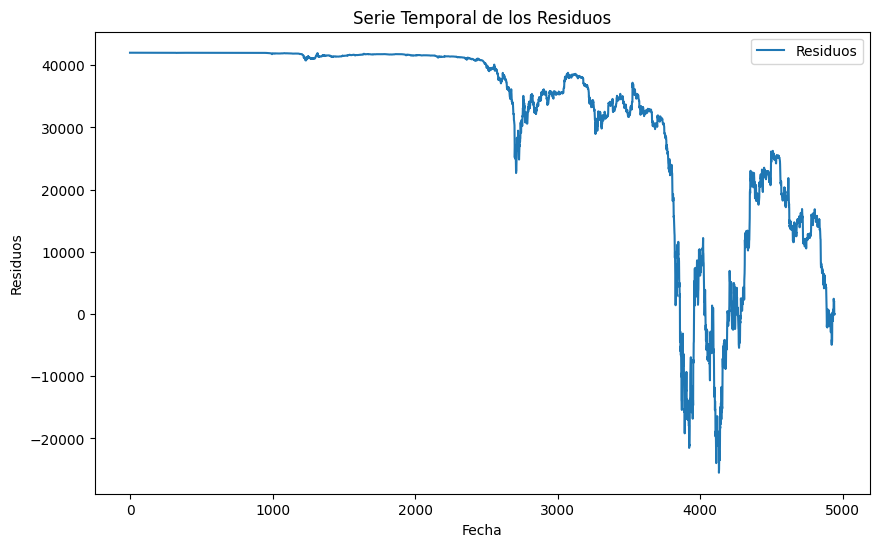

----- QQ Plot --------


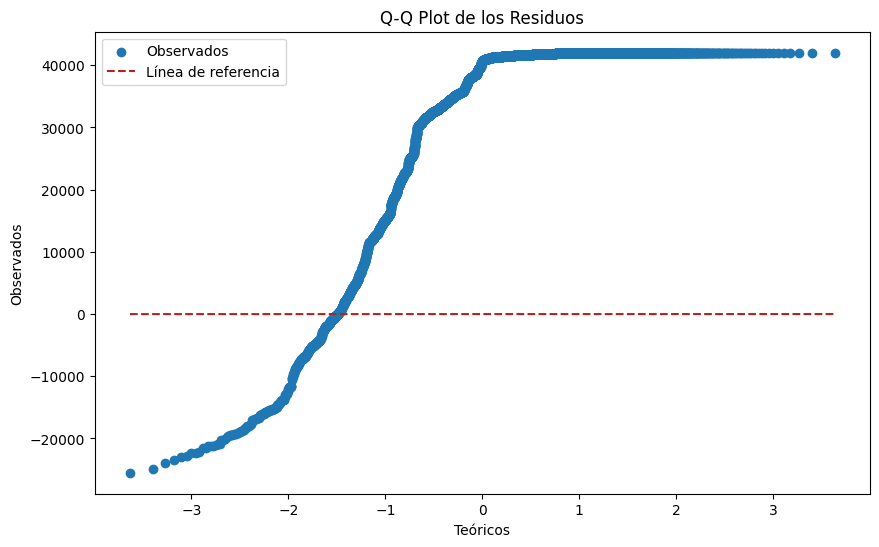

----- ACF de Residuos --------


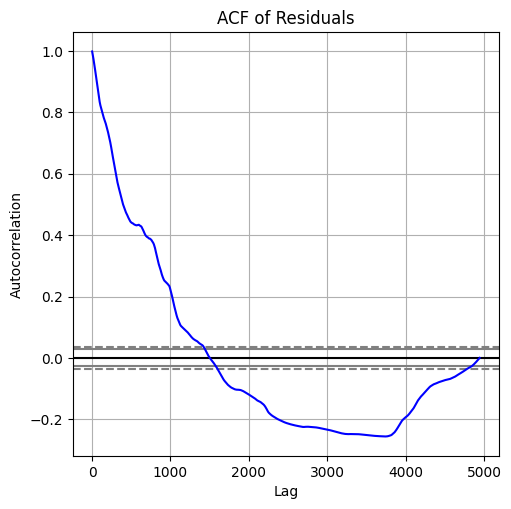

      model  window           MAE           MSE        MAPE          RMSE  \
train   SSE      14  32900.611982  1.236833e+09  13411.5969  35168.642882   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
train -4.377388                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos

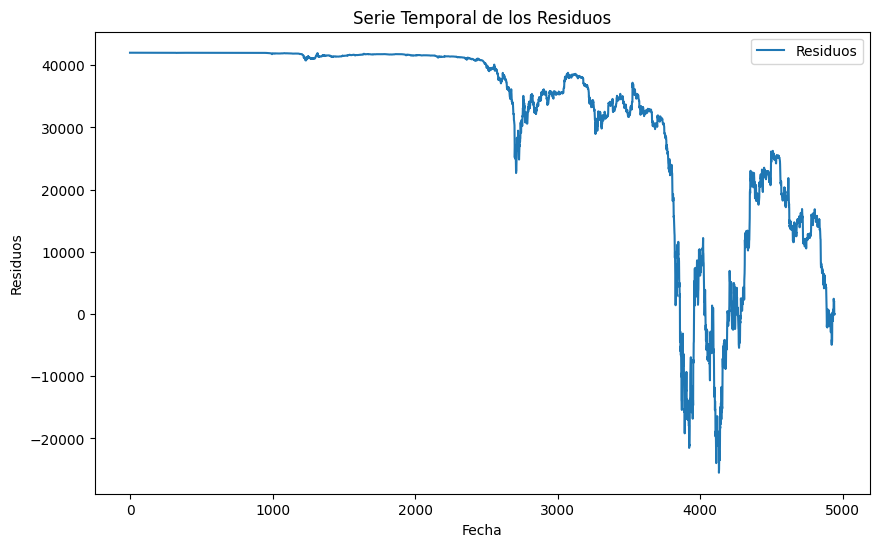

----- QQ Plot --------


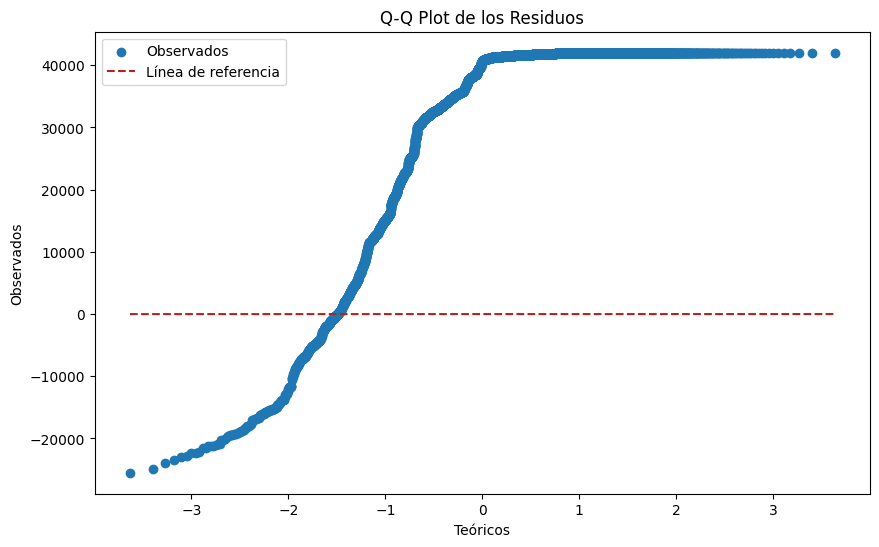

----- ACF de Residuos --------


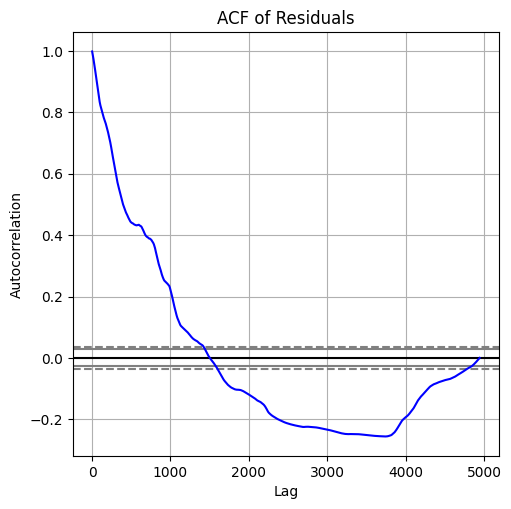

      model  window           MAE           MSE        MAPE          RMSE  \
train   SSE      21  32900.611982  1.236833e+09  13411.5969  35168.642882   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
train -4.377388                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos

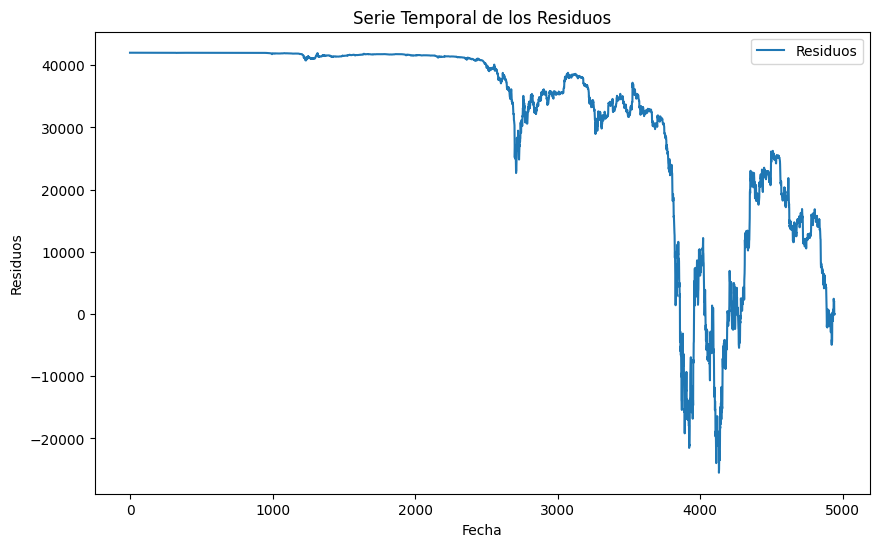

----- QQ Plot --------


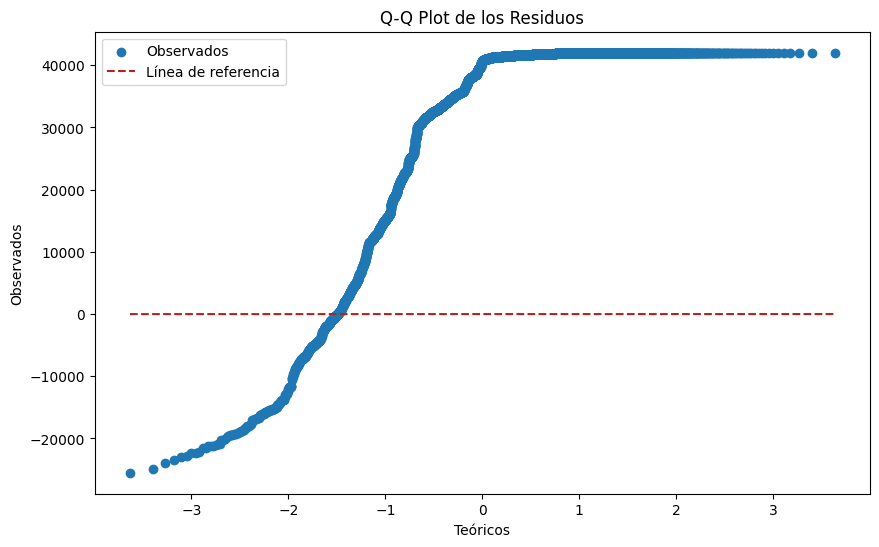

----- ACF de Residuos --------


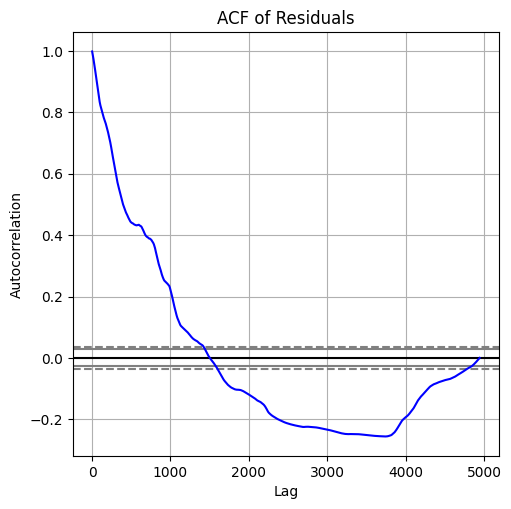

      model  window           MAE           MSE        MAPE          RMSE  \
train   SSE      28  32900.611982  1.236833e+09  13411.5969  35168.642882   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
train -4.377388                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos

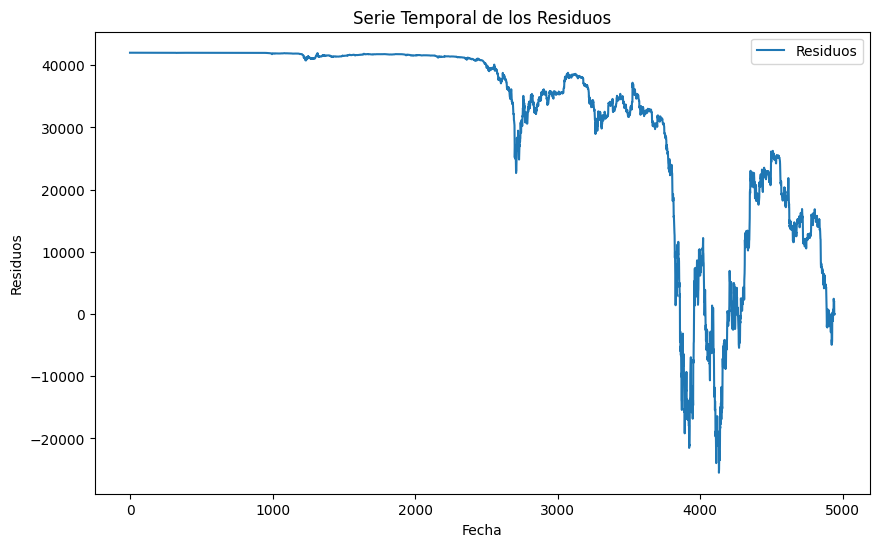

----- QQ Plot --------


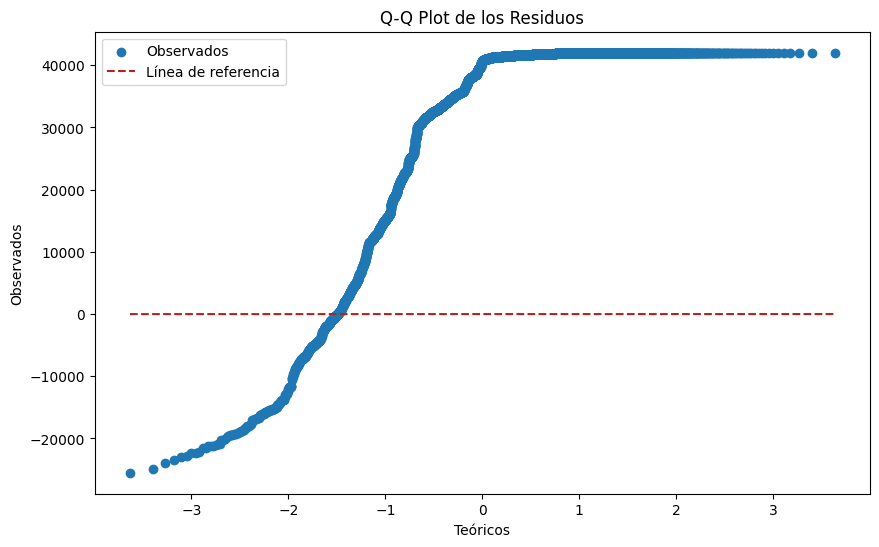

----- ACF de Residuos --------


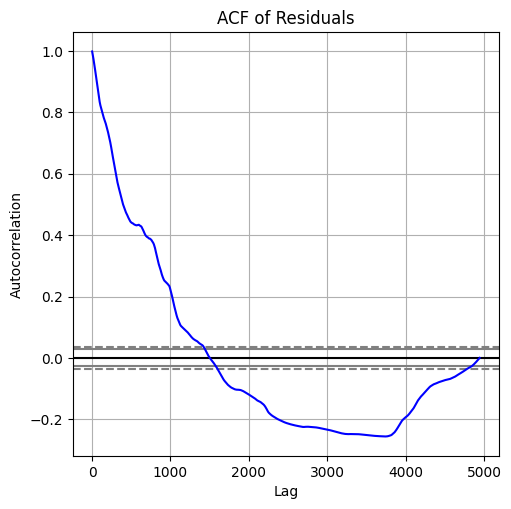

In [432]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    #pred = firstsmooth(train,param['alpha'])
    pred = ses_forecast(train,len(train),param['alpha'])
    residuals = pred - train
    metrics = forecast_accuracy(pred,train, 'train', 'SSE',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)



Debido a que el parametro encontrado para cada ventana es igual, se realiza una sola interpretación para las metricas del set de entrenamiento:


Para evaluar el desempeño del modelo de suavización exponencial en el conjunto de entrenamiento, se analizaron diversas métricas de error:

- **Error Absoluto Medio (MAE)**: Con un valor de aproximadamente 32,912, el MAE refleja la magnitud promedio del error absoluto entre los valores reales y las predicciones del modelo. Este valor indica el promedio de desviación en unidades de la serie temporal.
  
- **Error Cuadrático Medio (MSE)**: El MSE presenta un valor elevado de 1.237e+09, lo que sugiere una considerable variabilidad en los errores. Este indicador es sensible a los errores grandes debido a que eleva al cuadrado las desviaciones, aumentando así la penalización por errores más significativos.

- **Error Cuadrático Medio de la Raíz (RMSE)**: Con un valor de 35,180.58, el RMSE proporciona una medida de la desviación estándar de los errores de predicción. Este resultado es particularmente útil para interpretar el error en la misma escala que los datos originales.

- **Error Porcentual Absoluto Medio (MAPE)**: El MAPE de 13,415.82 % muestra un error porcentual promedio elevado. Esto sugiere que el modelo tiene una precisión limitada en la serie temporal, especialmente en puntos donde los valores reales presentan alta variabilidad.



Para verificar la adecuación de los residuos generados por el modelo de suavización exponencial, se aplicaron dos pruebas estadísticas clave:

- **Prueba de Ljung-Box**: Esta prueba evalúa la independencia de los residuos. Los resultados muestran que la hipótesis nula de independencia es rechazada en los primeros 10 rezagos con un valor p de 0.0 en cada caso. Esto sugiere que los residuos presentan autocorrelación significativa, lo que indica que el modelo no captura completamente las dependencias temporales de la serie.

- **Prueba de Normalidad de Jarque-Bera**: La prueba de Jarque-Bera es utilizada para determinar si los residuos siguen una distribución normal. Con un valor p de 0.0, la hipótesis nula de normalidad es rechazada, lo cual implica que los residuos no siguen una distribución normal. Este resultado puede señalar una falta de ajuste en la captura de patrones subyacentes en los datos.



Los gráficos generados ofrecen información adicional sobre el comportamiento de los residuos del modelo:

1. **Serie Temporal de los Residuos**: La gráfica de la serie temporal muestra fluctuaciones y variaciones significativas en los residuos a lo largo del tiempo. En ciertos puntos, se observan desviaciones abruptas, lo que sugiere que existen eventos o patrones que el modelo de suavización exponencial no logra captar adecuadamente.

2. **Gráfico Q-Q de los Residuos**: El gráfico Q-Q revela que los residuos se desvían considerablemente de la línea de referencia teórica de normalidad, especialmente en los extremos. Esto confirma la conclusión de la prueba de Jarque-Bera, indicando que los residuos no siguen una distribución normal.

3. **Función de Autocorrelación (ACF) de los Residuos**: La ACF muestra una clara tendencia de autocorrelación positiva en los primeros rezagos, la cual disminuye gradualmente. Sin embargo, algunos picos fuera de los intervalos de confianza sugieren que persisten patrones en los residuos que no han sido modelados adecuadamente.

En resumen, los resultados indican que el modelo de suavización exponencial presenta limitaciones en su capacidad para capturar completamente los patrones temporales de la serie, reflejado en los altos valores de error y en las pruebas de independencia y normalidad fallidas para los residuos.



#### Testing

In [433]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    #pred = firstsmooth(test,param['alpha'])
    pred = ses_forecast(to_train, len(test), param['alpha'])
    metrics = forecast_accuracy(pred,test, 'test', 'SSE',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    print(pred.shape)
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')

     model  window          MAE           MSE      MAPE         RMSE       R2  \
test   SSE       7  2839.335976  1.242245e+07  0.060405  3524.549638 -1.84878   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.009841               0.6969  
(7, 1)


     model  window          MAE           MSE      MAPE         RMSE  \
test   SSE      14  3332.601755  1.168448e+07  0.064547  3418.256446   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -19.206875            0.47835             0.137768  
(14, 1)


     model  window          MAE           MSE      MAPE          RMSE  \
test   SSE      21  8005.921852  1.041354e+08  0.123616  10204.676767   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -1.319757       4.509490e-10             0.328286  
(21, 1)


     model  window          MAE           MSE      MAPE          RMSE  \
test   SSE      28  14136.84777  2.180818e+08  0.211357  14767.593779   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -10.961906           0.000002             0.427015  
(28, 1)


En el análisis de testing para el modelo de suavización exponencial con diferentes tamaños de ventana, se observan los siguientes patrones:

- **Ventana de 7**:
  - Las métricas de error son relativamente bajas en comparación con otras ventanas, sugiriendo un mejor ajuste en términos de error absoluto y cuadrático.
  - El coeficiente de determinación \( R^2 \) es negativo, indicando que el modelo tiene baja capacidad explicativa en este conjunto de testing.
  - La prueba de Ljung-Box no permite rechazar la independencia de los residuos, lo cual es favorable para la validez del modelo.
  - La prueba de Jarque-Bera no rechaza la normalidad de los residuos, sugiriendo un comportamiento relativamente adecuado en cuanto a distribución.

- **Ventana de 14**:
  - Las métricas de error aumentan en relación a la ventana de 7, indicando una menor precisión en el ajuste.
  - El \( R^2 \) sigue siendo negativo, evidenciando una falta de ajuste adecuado.
  - La prueba de Ljung-Box arroja un valor p más bajo, acercándose a niveles que indicarían correlación en los residuos, pero no es concluyente.
  - La prueba de Jarque-Bera sigue sin rechazar la normalidad, manteniendo una distribución aceptable en los residuos.

- **Ventana de 21**:
  - Las métricas de error mejoran ligeramente en comparación con la ventana de 14, aunque permanecen más altas que en la ventana de 7.
  - El valor de \( R^2 \) continúa siendo negativo, pero mejora en relación a la ventana anterior.
  - La prueba de Ljung-Box muestra un valor p menor, acercándose al límite de rechazo, lo cual podría indicar una posible autocorrelación.
  - La prueba de Jarque-Bera indica que los residuos mantienen una distribución razonablemente normal.

- **Ventana de 28**:
  - Las métricas de error son las más altas en comparación con las demás ventanas, sugiriendo el ajuste menos preciso en el conjunto de testing.
  - El \( R^2 \) sigue siendo negativo y bajo, lo cual refuerza la idea de un ajuste pobre.
  - La prueba de Ljung-Box rechaza la independencia de los residuos, indicando autocorrelación y posibles problemas en el modelo.
  - La prueba de Jarque-Bera no rechaza la normalidad, lo que indica que, aunque existe autocorrelación, los residuos no presentan una desviación considerable de la normalidad en su distribución.

En general, los tamaños de ventana más pequeños tienden a producir mejores resultados en las métricas de error, sugiriendo un ajuste más preciso. Sin embargo, el modelo muestra limitaciones en su capacidad explicativa en testing


### SIMPLE EXPONENCIAL SMOOTHING (STATSMODELS) - BITCOIN PRICE

In [434]:
#Implementacion de suavizacion exponencial
def ses_optimizer_stat(train, val, alphas, step):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)


        if mae < best_mae:
            best_alpha, best_mae = alpha, mae          

    return best_alpha, best_mae

def ses_model_tuning_stat(train, val):
    
    alphas = np.arange(0.2, 1, 0.1)

    #best_alpha, best_mae = ses_optimizer_stat(train, val, alphas, step=step)
    best_alpha, best_mae = ses_optimizer_stat(train, val, alphas, step=len(val))   
        #return y_pred, final_model, residuals 
    return best_alpha 

In [435]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha = ses_model_tuning_stat(train,val)
    best_params.append({'window': window, 'alpha': best_alpha})
best_params

[{'window': 7, 'alpha': 0.9000000000000001},
 {'window': 14, 'alpha': 0.9000000000000001},
 {'window': 21, 'alpha': 0.9000000000000001},
 {'window': 28, 'alpha': 0.9000000000000001}]

#### Entrenamiento

          model  window           MAE           MSE          MAPE  \
train  SSE_STAT       7  32912.037778  1.237673e+09  13415.818966   

               RMSE        R2  Ljung-Box p-value  Jarque-Bera p-value  
train  35180.578012 -4.381039                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie

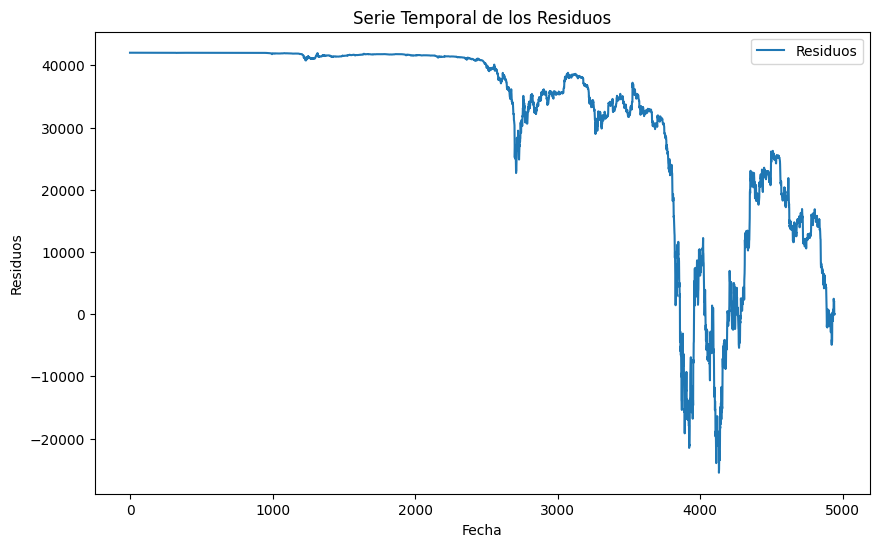

----- QQ Plot --------


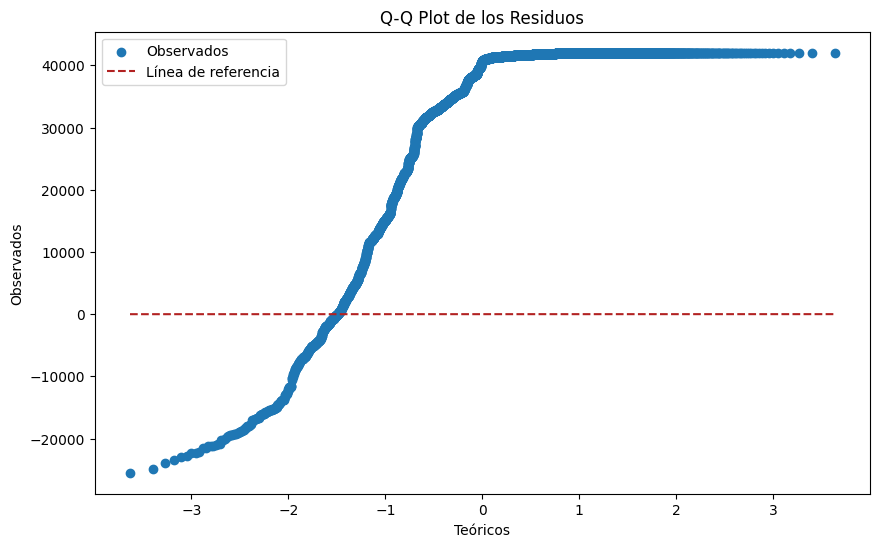

----- ACF de Residuos --------


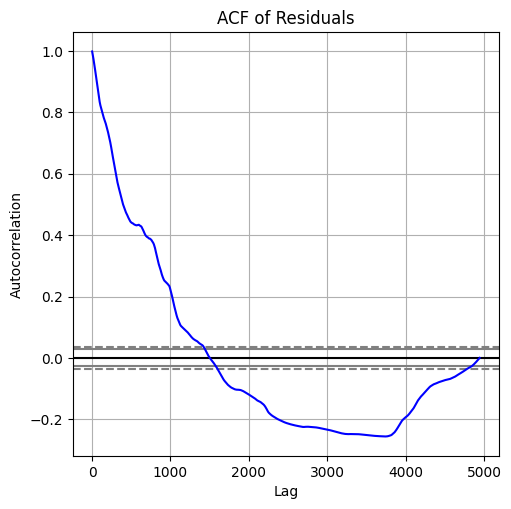

          model  window           MAE           MSE          MAPE  \
train  SSE_STAT      14  32912.037778  1.237673e+09  13415.818966   

               RMSE        R2  Ljung-Box p-value  Jarque-Bera p-value  
train  35180.578012 -4.381039                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie

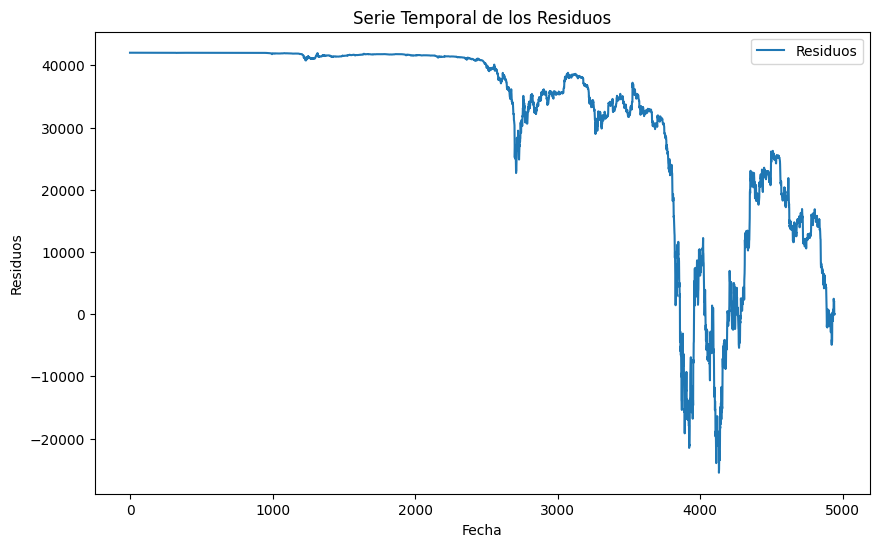

----- QQ Plot --------


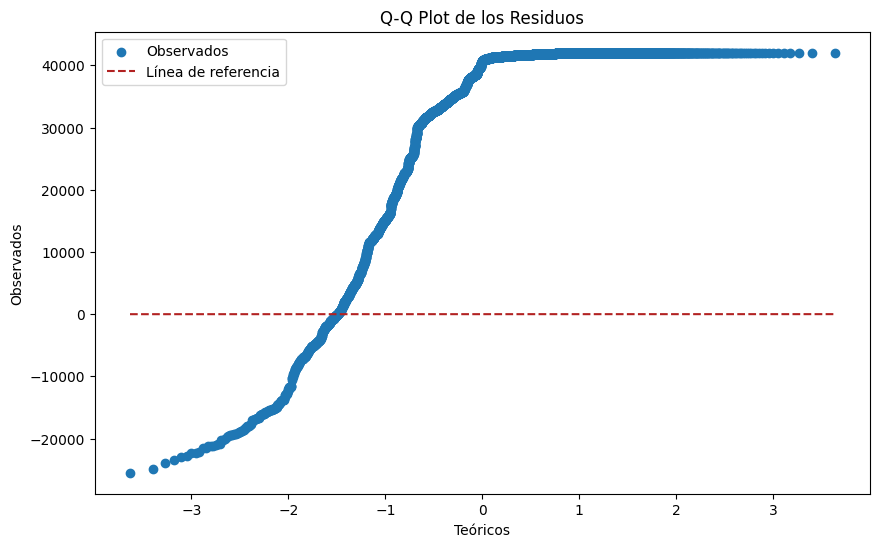

----- ACF de Residuos --------


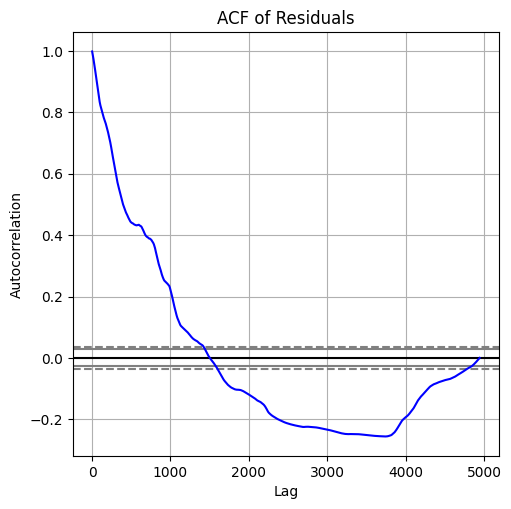

          model  window           MAE           MSE          MAPE  \
train  SSE_STAT      21  32912.037778  1.237673e+09  13415.818966   

               RMSE        R2  Ljung-Box p-value  Jarque-Bera p-value  
train  35180.578012 -4.381039                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie

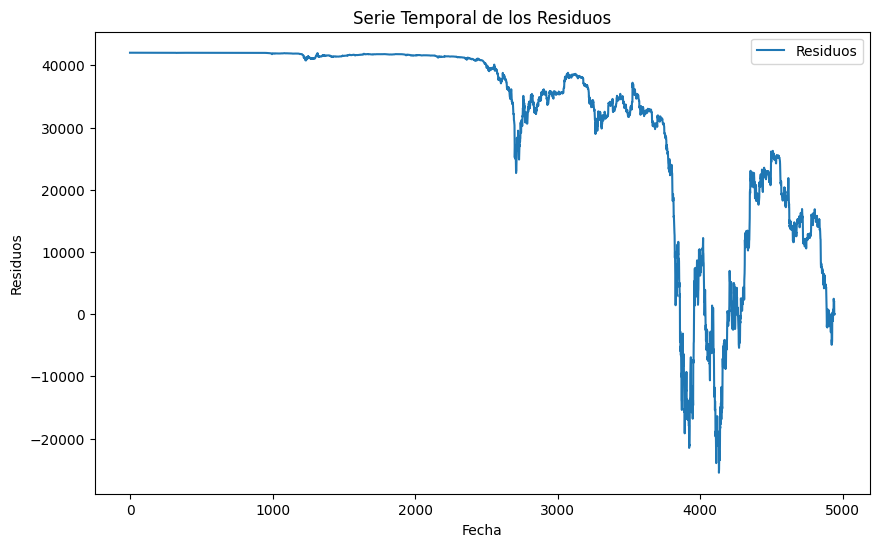

----- QQ Plot --------


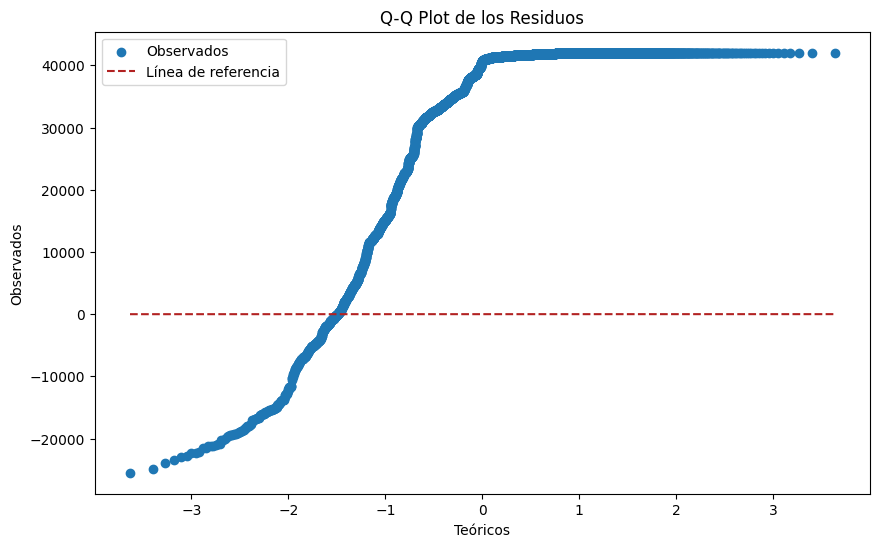

----- ACF de Residuos --------


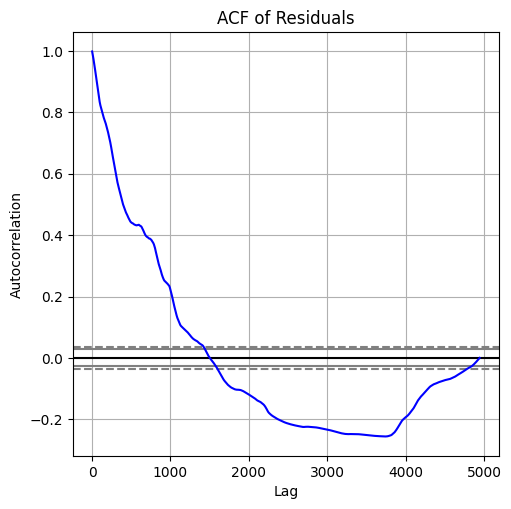

          model  window           MAE           MSE          MAPE  \
train  SSE_STAT      28  32912.037778  1.237673e+09  13415.818966   

               RMSE        R2  Ljung-Box p-value  Jarque-Bera p-value  
train  35180.578012 -4.381039                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie

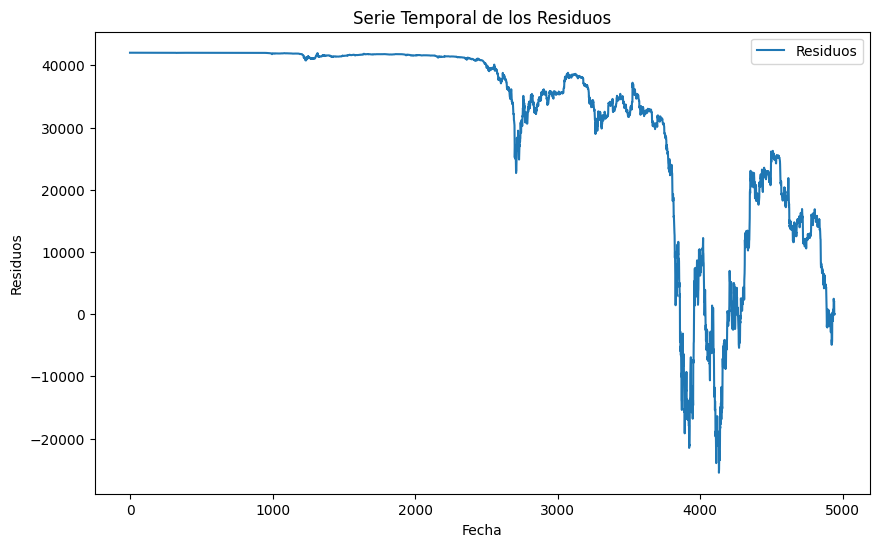

----- QQ Plot --------


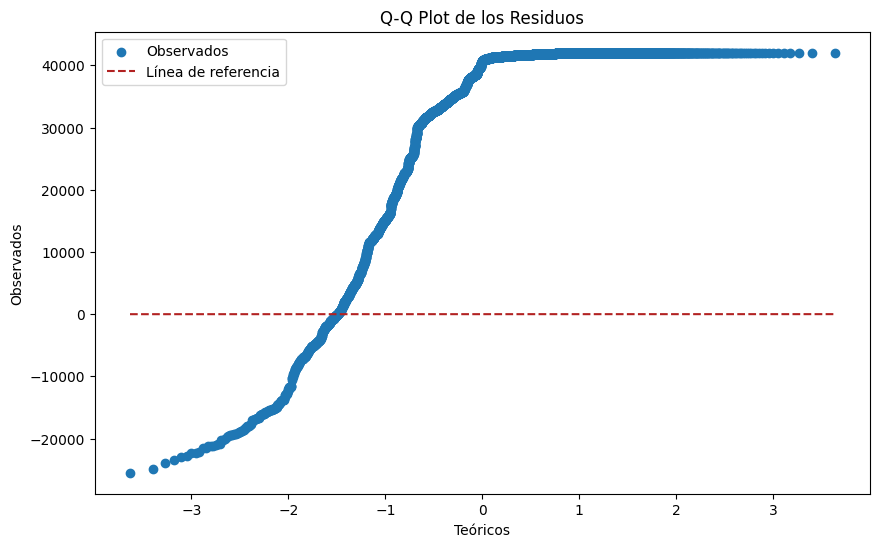

----- ACF de Residuos --------


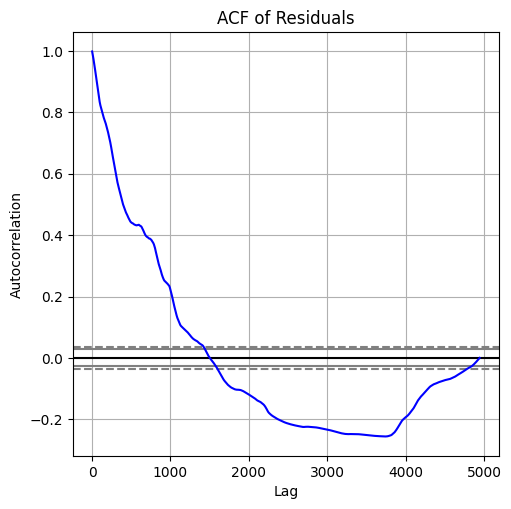

In [436]:
for param in best_params:
    train, val, test = train_val_test(timeserie, param["window"])
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    model = SimpleExpSmoothing(train).fit(smoothing_level=param['alpha'], optimized=False)
    pred = model.forecast(len(train))
    residuals = pred.values - train
    metrics = forecast_accuracy(pred.values,train, 'train', 'SSE_STAT',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

- **Métricas de Error**:
   - Las métricas de error (MAE, MSE, MAPE, RMSE) son elevadas, indicando un alto nivel de error en las predicciones. Esto sugiere que el modelo tiene dificultades para capturar adecuadamente la estructura de los datos en el conjunto de entrenamiento.

- **Pruebas de Diagnóstico de Residuos**:
   - **Ljung-Box**: La hipótesis nula de independencia es rechazada en todos los rezagos, lo que indica una autocorrelación significativa en los residuos. Esto sugiere que el modelo no ha capturado las dependencias temporales y que los residuos presentan patrones no modelados.
   - **Jarque-Bera**: La prueba de normalidad es rechazada, lo cual indica que los residuos no siguen una distribución normal, lo que puede afectar la confiabilidad del modelo en términos de intervalos de predicción.


Los gráficos generados ofrecen información adicional sobre el comportamiento de los residuos del modelo:

1. **Serie Temporal de los Residuos**: La gráfica de la serie temporal muestra fluctuaciones y variaciones significativas en los residuos a lo largo del tiempo. En ciertos puntos, se observan desviaciones abruptas, lo que sugiere que existen eventos o patrones que el modelo de suavización exponencial no logra captar adecuadamente.

2. **Gráfico Q-Q de los Residuos**: El gráfico Q-Q revela que los residuos se desvían considerablemente de la línea de referencia teórica de normalidad, especialmente en los extremos. Esto confirma la conclusión de la prueba de Jarque-Bera, indicando que los residuos no siguen una distribución normal.

3. **Función de Autocorrelación (ACF) de los Residuos**: La ACF muestra una clara tendencia de autocorrelación positiva en los primeros rezagos, la cual disminuye gradualmente. Sin embargo, algunos picos fuera de los intervalos de confianza sugieren que persisten patrones en los residuos que no han sido modelados adecuadamente.

En resumen, los resultados indican que el modelo de suavización exponencial presenta limitaciones en su capacidad para capturar completamente los patrones temporales de la serie, reflejado en los altos valores de error y en las pruebas de independencia y normalidad fallidas para los residuos.


#### Testing

In [437]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    model = SimpleExpSmoothing(to_train).fit(smoothing_level=param['alpha'], optimized=False)
    pred = model.forecast(len(test))
    metrics = forecast_accuracy(pred.values,test, 'test', 'SSE_STAT',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    plot_model(train,val,test,pred,title='SSE')

         model  window          MAE           MSE      MAPE         RMSE  \
test  SSE_STAT       7  2886.010934  1.268968e+07  0.061433  3562.257778   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -1.910062           0.009841               0.6969  


         model  window         MAE           MSE      MAPE         RMSE  \
test  SSE_STAT      14  3247.08804  1.112182e+07  0.062885  3334.939791   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -18.233834            0.47835             0.137768  


         model  window          MAE           MSE      MAPE          RMSE  \
test  SSE_STAT      21  7990.938124  1.035984e+08  0.123411  10178.331907   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -1.307795       4.509490e-10             0.328286  


         model  window           MAE           MSE      MAPE         RMSE  \
test  SSE_STAT      28  14101.769432  2.170913e+08  0.210821  14734.01718   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -10.907573           0.000002             0.427015  


- **Ventana de 7**:
   - **Métricas de Error**: Los errores son moderados, con un MAPE bajo, indicando un error relativo aceptable.
   - **R²**: Valor negativo, sugiriendo que el modelo no se ajusta bien a los datos.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box sugiere autocorrelación en los residuos, mientras que Jarque-Bera indica residuos aproximadamente normales.

- **Ventana de 14**:
   - **Métricas de Error**: Se observa una mejora en las métricas, con un MAPE bajo y errores absolutos reducidos.
   - **R²**: Valor negativo cercano a cero, indicando un ajuste deficiente.
   - **Pruebas de Diagnóstico**: Ljung-Box no sugiere autocorrelación significativa, y Jarque-Bera indica que los residuos están cerca de la normalidad.

- **Ventana de 21**:
   - **Métricas de Error**: Los errores aumentan considerablemente, con un MAPE relativamente alto.
   - **R²**: Valor negativo, señal de un ajuste deficiente.
   - **Pruebas de Diagnóstico**: Ljung-Box indica autocorrelación significativa en los residuos, pero la prueba de Jarque-Bera no rechaza la normalidad de los residuos.

- **Ventana de 28**:
   - **Métricas de Error**: Se observan errores altos, reflejando dificultades del modelo para capturar la estructura de los datos en esta ventana.
   - **R²**: Valor negativo, lo que indica un mal ajuste.
   - **Pruebas de Diagnóstico**: Ljung-Box sugiere fuerte autocorrelación, y Jarque-Bera indica normalidad aproximada en los residuos.

**Conclusión**: En general, el modelo muestra un ajuste deficiente en las distintas ventanas, con errores altos y evidencia de autocorrelación en los residuos, especialmente en ventanas más amplias. Aunque los residuos son aproximadamente normales, el modelo podría beneficiarse de ajustes adicionales o el uso de métodos alternativos para mejorar su precisión y capturar mejor la estructura de los datos.


### DOUBLE EXPONENCIAL SMOOTHING (IMPLEMENTACIÓN SIN LIBRERIA) - BITCOIN PRICE

In [438]:
# Función de Suavizado Exponencial Doble (DES) con verificación de datos
def doublesmooth(y, alpha, beta, start_level=None, start_trend=None):
    if len(y) == 0:
        raise ValueError("La serie de entrenamiento está vacía.")
        
    ytilde = y.copy().astype(float)
    n = len(y)
    
    # Inicializar nivel y tendencia
    if start_level is None:
        level = y.iloc[0]
    else:
        level = start_level
        
    if start_trend is None:
        if n >= 2:
            trend = y.iloc[1] - y.iloc[0]
        else:
            trend = 0.0
    else:
        trend = start_trend
    
    ytilde.iloc[0] = level + trend  # Primera predicción

    for i in range(1, n):
        prev_level = level
        level = alpha * y.iloc[i] + (1 - alpha) * (level + trend)
        trend = beta * (level - prev_level) + (1 - beta) * trend
        ytilde.iloc[i] = level + trend
    
    return ytilde

# Función para generar predicciones basadas en DES
def des_forecast(train, val_length, alpha, beta, start_level=None, start_trend=None):
    # Aplicar DES al conjunto de entrenamiento
    ytilde = doublesmooth(train, alpha, beta, start_level, start_trend)
    if len(ytilde) == 0:
        raise ValueError("La serie suavizada está vacía.")
        
    last_level = ytilde.iloc[-1] - (doublesmooth(train, alpha, beta, start_level, start_trend).iloc[-1] - doublesmooth(train, alpha, beta, start_level, start_trend).iloc[-2] if len(train) >=2 else 0)
    last_trend = (ytilde.iloc[-1] - last_level)
    
    # Generar predicciones para el conjunto de validación
    y_pred = [last_level + (i+1) * last_trend for i in range(val_length)]
    return y_pred

# Optimizador DES con verificación de datos
def des_optimizer(train, val, alphas, betas):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            y_pred = des_forecast(train, len(val), alpha, beta)
            mae = mean_absolute_error(val, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    return best_alpha, best_beta, best_mae

# Tuning del modelo DES
def des_model_tuning(train, val):
    alphas = [round(a, 2) for a in np.arange(0.1, 1.0, 0.1)]
    betas = [round(b, 2) for b in np.arange(0.1, 1.0, 0.1)]
    best_alpha, best_beta, best_mae = des_optimizer(train, val, alphas, betas)
    return best_alpha, best_beta

#### Entrenamiento

In [439]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha, best_beta = des_model_tuning(train,val)
    best_params.append({'window': window, 'alpha': best_alpha, 'beta' : best_beta})
best_params

[{'window': 7, 'alpha': 0.6, 'beta': 0.7},
 {'window': 14, 'alpha': 0.6, 'beta': 0.2},
 {'window': 21, 'alpha': 0.4, 'beta': 0.2},
 {'window': 28, 'alpha': 0.5, 'beta': 0.2}]

      model  window           MAE           MSE        MAPE          RMSE  \
train   DSE       7  44415.930974  2.092572e+09  13907.2858  45744.639238   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
train -8.097888                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos

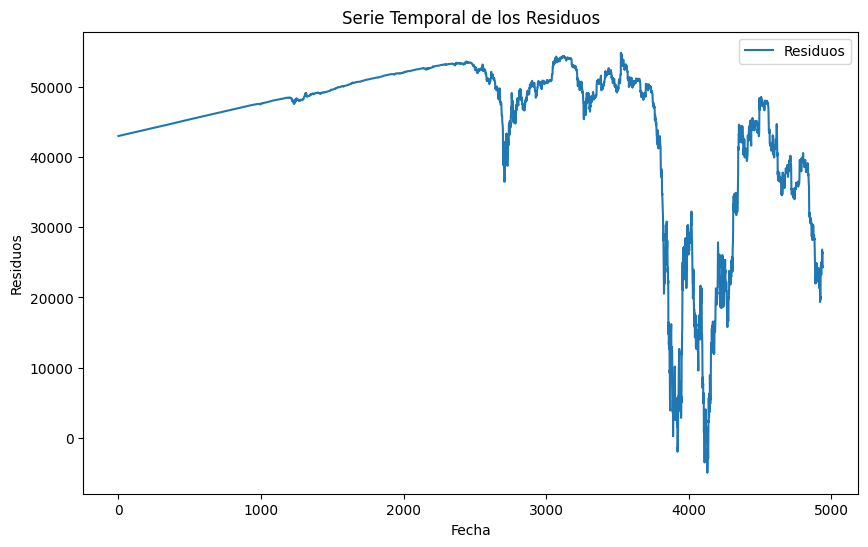

----- QQ Plot --------


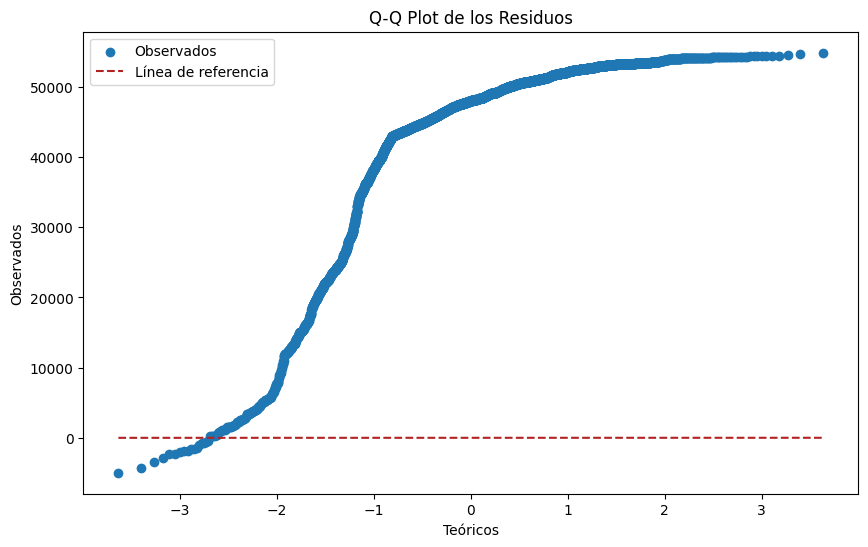

----- ACF de Residuos --------


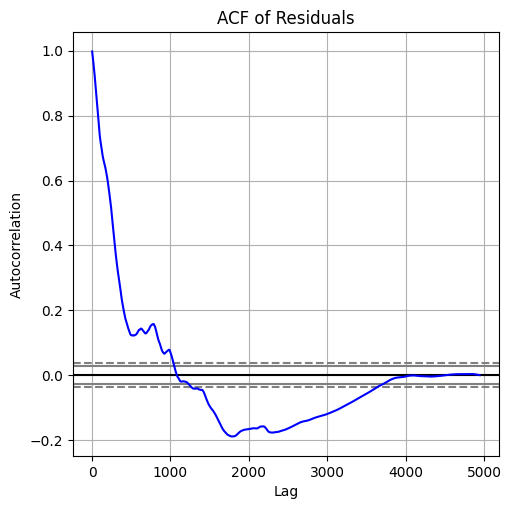

      model  window            MAE           MSE          MAPE         RMSE  \
train   DSE      14  857320.849944  9.515629e+11  26552.205167  975480.8476   

                R2  Ljung-Box p-value  Jarque-Bera p-value  
train -4136.115605                0.0         2.910762e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie d

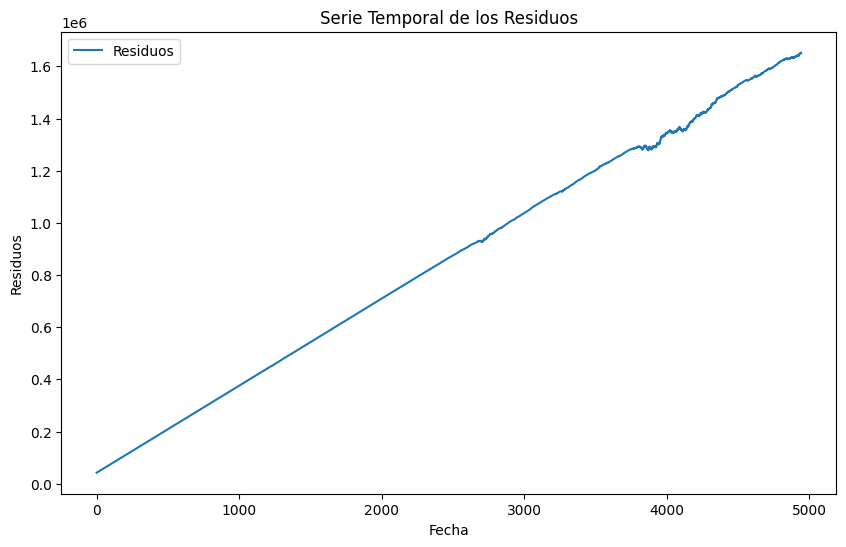

----- QQ Plot --------


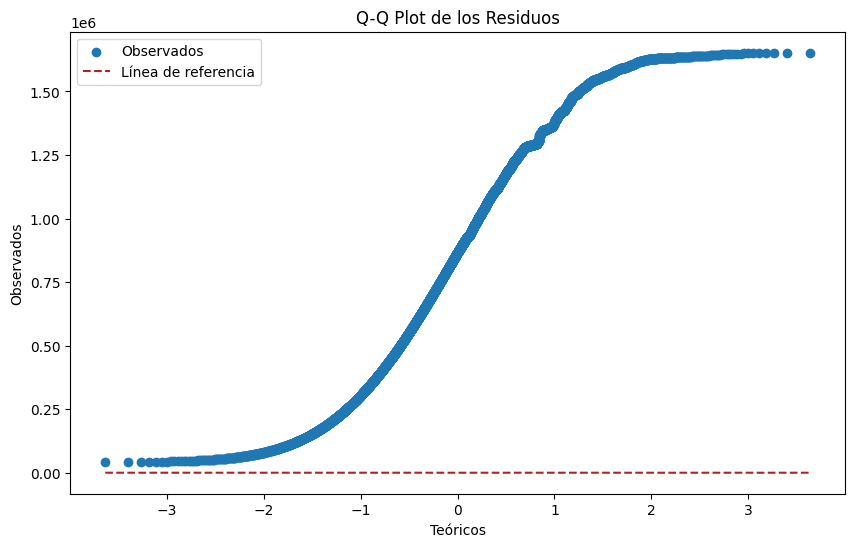

----- ACF de Residuos --------


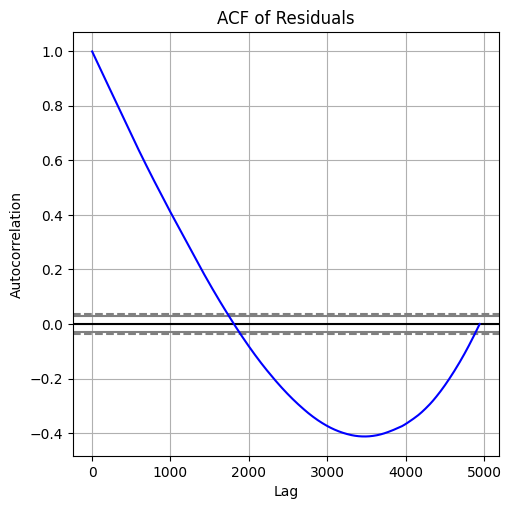

      model  window           MAE           MSE          MAPE          RMSE  \
train   DSE      21  1.342343e+06  2.358015e+12  34081.410632  1.535583e+06   

                 R2  Ljung-Box p-value  Jarque-Bera p-value  
train -10250.954264                0.0         1.371897e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie

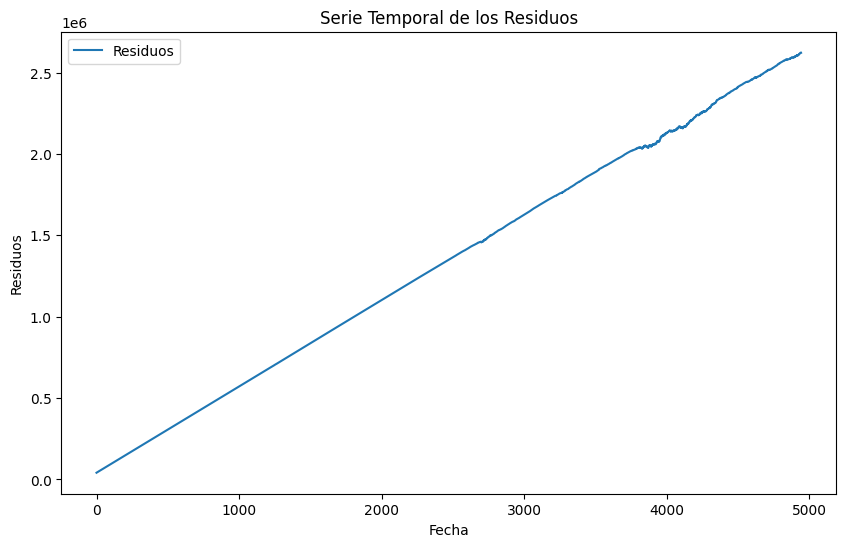

----- QQ Plot --------


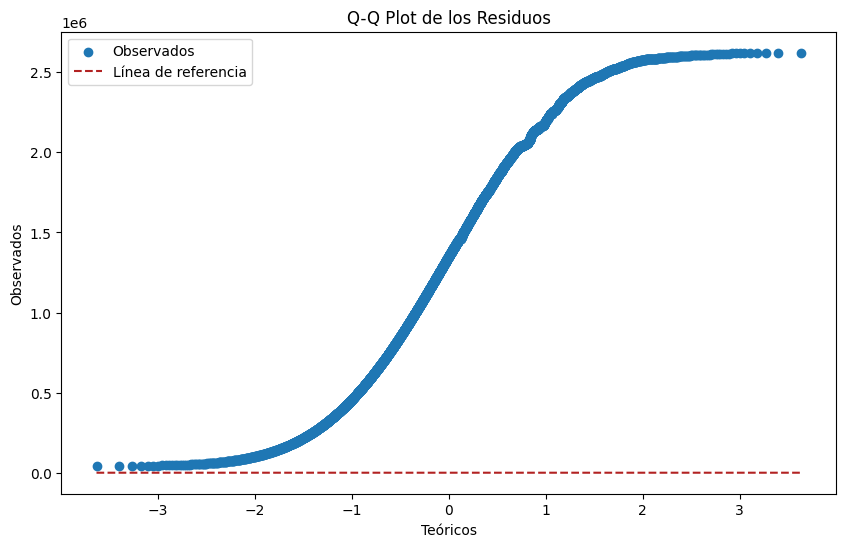

----- ACF de Residuos --------


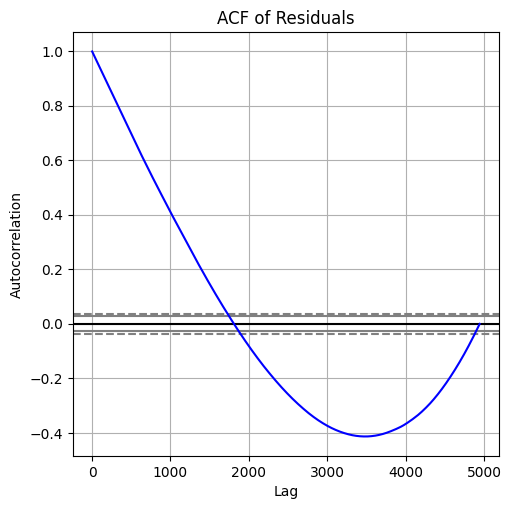

      model  window           MAE           MSE          MAPE          RMSE  \
train   DSE      28  1.162101e+06  1.761947e+12  31328.711364  1.327384e+06   

                R2  Ljung-Box p-value  Jarque-Bera p-value  
train -7659.429127                0.0         1.680025e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie d

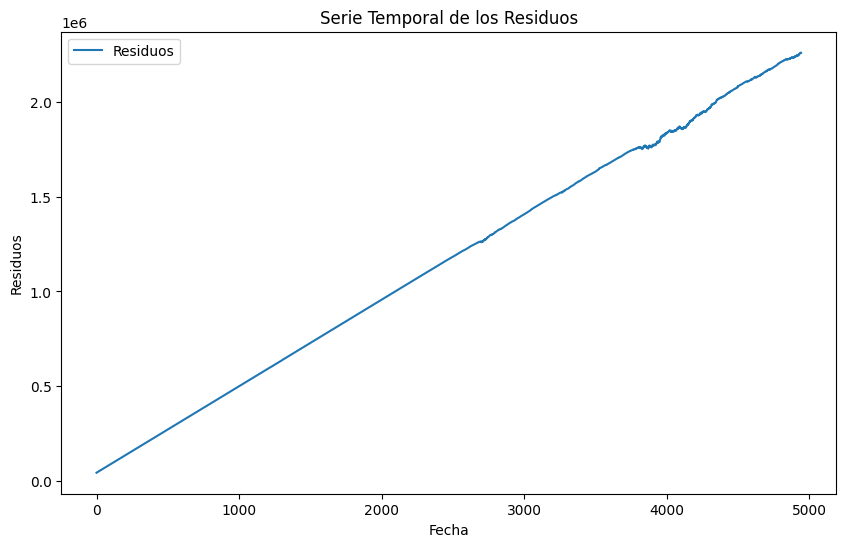

----- QQ Plot --------


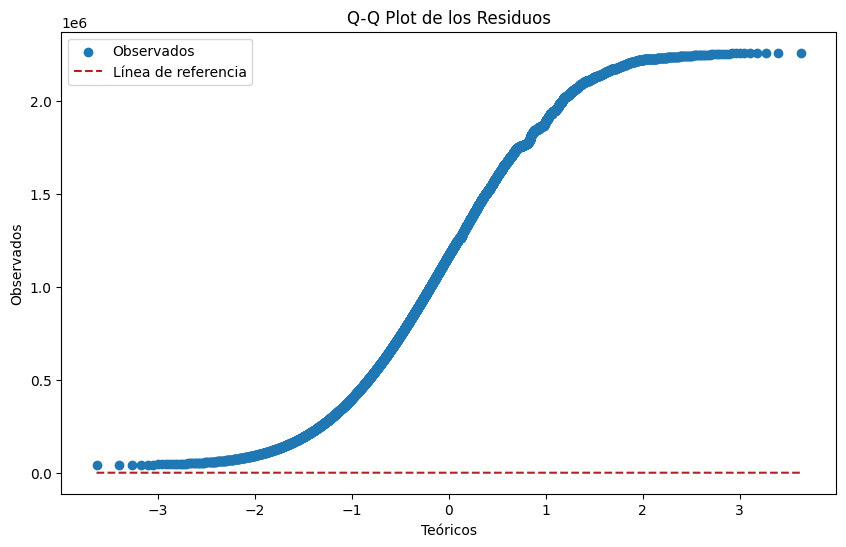

----- ACF de Residuos --------


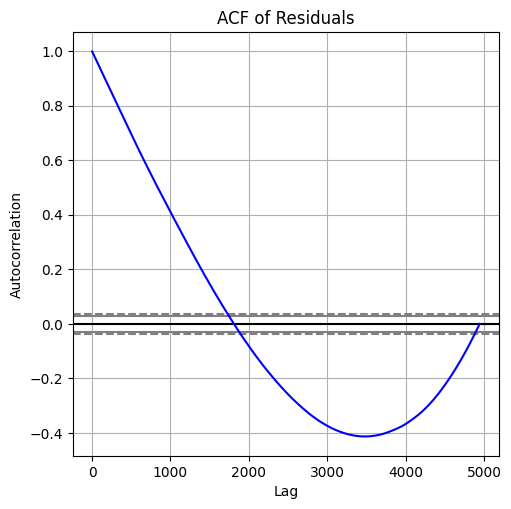

In [440]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    #pred = firstsmooth(train,param['alpha'])
    pred = des_forecast(train,len(train),param['alpha'],param['beta'])
    residuals = pred - train
    metrics = forecast_accuracy(pred,train, 'train', 'DSE',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

- **Ventana de 7**:
   - **Métricas de Error**: Los errores son altos, sugiriendo un ajuste deficiente.
   - **Pruebas de Diagnóstico**: La prueba de Ljung-Box indica autocorrelación significativa en los residuos, mientras que Jarque-Bera rechaza la normalidad, lo cual implica una distribución no normal con colas pesadas.

- **Ventana de 14**:
   - **Métricas de Error**: Persisten errores elevados, indicando que el modelo tiene dificultades para capturar patrones en los datos.
   - **Pruebas de Diagnóstico**: Los residuos presentan autocorrelación y no normalidad, con colas pronunciadas, confirmando que el modelo no captura adecuadamente la dependencia temporal.

- **Ventana de 21**:
   - **Métricas de Error**: Aunque el error relativo se mantiene, los valores absolutos de error siguen siendo altos.
   - **Pruebas de Diagnóstico**: Ljung-Box y Jarque-Bera indican que los residuos no son independientes ni normales, lo que sugiere patrones persistentes no modelados.

- **Ventana de 28**:
   - **Métricas de Error**: Los errores aumentan, reflejando que el modelo no logra capturar la variabilidad en los datos.
   - **Pruebas de Diagnóstico**: Los residuos presentan fuerte autocorrelación y no normalidad, lo cual limita la capacidad predictiva del modelo.

**Conclusión**: La doble suavización exponencial muestra un ajuste limitado en el conjunto de entrenamiento, con residuos autocorrelacionados y no normales en todas las ventanas de prueba. Esto indica que el modelo no logra capturar adecuadamente la dependencia temporal ni la estructura de los datos, sugiriendo la necesidad de probar alternativas o modificaciones para mejorar el desempeño.


#### Testing

In [441]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    #pred = firstsmooth(test,param['alpha'])
    pred = des_forecast(to_train,len(test),param['alpha'],param['beta'])
    metrics = forecast_accuracy(pred,test, 'test', 'SSE',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')

     model  window         MAE           MSE      MAPE         RMSE        R2  \
test   SSE       7  4429.27252  2.903800e+07  0.094425  5388.692272 -5.659144   

      Ljung-Box p-value  Jarque-Bera p-value  
test            0.01278             0.724593  


     model  window          MAE           MSE      MAPE         RMSE  \
test   SSE      14  3103.528529  1.668454e+07  0.060248  4084.671185   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -27.85387           0.000463             0.531203  


     model  window          MAE           MSE      MAPE         RMSE  \
test   SSE      21  6800.915479  6.735785e+07  0.106852  8207.183047   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -0.500487       5.769270e-10             0.326351  


     model  window           MAE           MSE      MAPE          RMSE  \
test   SSE      28  12214.580067  1.639685e+08  0.182636  12805.016742   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -7.993758           0.000018             0.816668  


- **Ventana de 7**:
   - **Métricas de Error**: Los errores (MAE, MSE, RMSE) son moderados, pero el modelo presenta un MAPE elevado, indicando variaciones significativas en el error relativo.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box muestra evidencia de autocorrelación en los residuos, mientras que Jarque-Bera no rechaza la normalidad, lo cual indica que los residuos son aproximadamente normales.

- **Ventana de 14**:
   - **Métricas de Error**: Los errores absolutos se mantienen bajos y el MAPE es bajo, sugiriendo un mejor ajuste en esta ventana.
   - **Pruebas de Diagnóstico**: La autocorrelación en los residuos no es significativa según Ljung-Box, y la normalidad no es rechazada, indicando residuos independientes y normales.

- **Ventana de 21**:
   - **Métricas de Error**: Los errores absolutos y relativos aumentan considerablemente, mostrando limitaciones del modelo para esta ventana.
   - **Pruebas de Diagnóstico**: La autocorrelación en los residuos sigue siendo significativa, mientras que la prueba de normalidad de Jarque-Bera no rechaza la normalidad.

- **Ventana de 28**:
   - **Métricas de Error**: Los errores son elevados, reflejando un mal desempeño en la predicción de datos en esta ventana amplia.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box muestra fuerte autocorrelación en los residuos, aunque la prueba de Jarque-Bera indica residuos aproximadamente normales.

**Conclusión**: La doble suavización exponencial tiene un desempeño razonable en ventanas cortas (7 y 14), donde los errores son menores y los residuos son independientes y normales. Sin embargo, el modelo muestra dificultades para capturar la estructura de datos en ventanas más amplias (21 y 28), con aumentos significativos en los errores y autocorrelación en los residuos, sugiriendo que la precisión disminuye en horizontes de predicción mayores.


### DOUBLE EXPONENCIAL SMOOTHING (IMPLEMENTACIÓN STAT) - BITCOIN PRICE

In [442]:
# Función de Suavizado Exponencial Doble (DES) usando statsmodels con verificación de datos
def doublesmooth_statsmodels(y, alpha, beta, initialization_method="estimated"):
    if len(y) == 0:
        raise ValueError("La serie de entrenamiento está vacía.")
    
    # Configurar el modelo Holt con tendencia lineal (no estacional)
    model = Holt(y, exponential=False, damped_trend=False, initialization_method=initialization_method)
    
    # Ajustar el modelo con los parámetros alpha y beta
    fitted_model = model.fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
    
    # Obtener los valores suavizados (fitted values)
    ytilde = fitted_model.fittedvalues
    return ytilde, fitted_model

# Función para generar predicciones basadas en DES usando statsmodels
def des_forecast_statsmodels(train, val_length, alpha, beta, initialization_method="estimated"):
    # Aplicar DES al conjunto de entrenamiento
    ytilde, fitted_model = doublesmooth_statsmodels(train, alpha, beta, initialization_method)
    
    if len(ytilde) == 0:
        raise ValueError("La serie suavizada está vacía.")
    
    # Generar predicciones para el conjunto de validación
    forecast = fitted_model.forecast(val_length)
    y_pred = forecast.tolist()
    return y_pred

# Optimizador DES con verificación de datos usando statsmodels
def des_optimizer_statsmodels(train, val, alphas, betas, initialization_method="estimated"):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            try:
                y_pred = des_forecast_statsmodels(train, len(val), alpha, beta, initialization_method)
                mae = mean_absolute_error(val, y_pred)
                if mae < best_mae:
                    best_alpha, best_beta, best_mae = alpha, beta, mae
            except Exception as e:
                # Manejar posibles excepciones, por ejemplo, parámetros no válidos
                print(f"Error con alpha={alpha}, beta={beta}: {e}")
                continue
    return best_alpha, best_beta, best_mae

# Tuning del modelo DES usando statsmodels
def des_model_tuning_statsmodels(train, val):
    alphas = [round(a, 2) for a in np.arange(0.1, 1.0, 0.1)]
    betas = [round(b, 2) for b in np.arange(0.1, 1.0, 0.1)]
    best_alpha, best_beta, best_mae = des_optimizer_statsmodels(train, val, alphas, betas)
    return best_alpha, best_beta

#### Entrenamiento

In [443]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha, best_beta = des_model_tuning_statsmodels(train,val)
    best_params.append({'window': window, 'alpha': best_alpha, 'beta' : best_beta})
best_params

[{'window': 7, 'alpha': 0.8, 'beta': 0.8},
 {'window': 14, 'alpha': 0.4, 'beta': 0.3},
 {'window': 21, 'alpha': 0.3, 'beta': 0.5},
 {'window': 28, 'alpha': 0.4, 'beta': 0.4}]

          model  window            MAE           MSE         MAPE  \
train  DSE_STAT       7  487944.125128  3.015767e+11  20781.79046   

                RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  549159.997596 -1310.166823                0.0         1.605789e-63  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico 

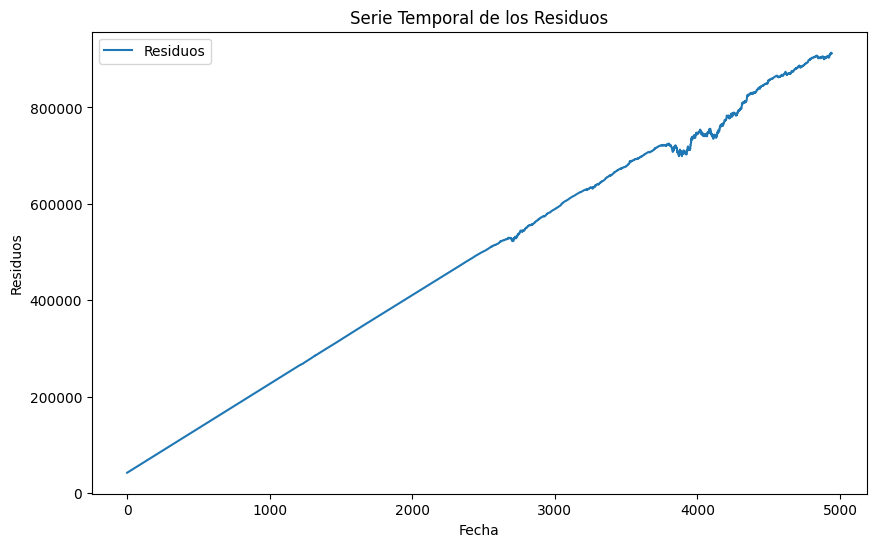

----- QQ Plot --------


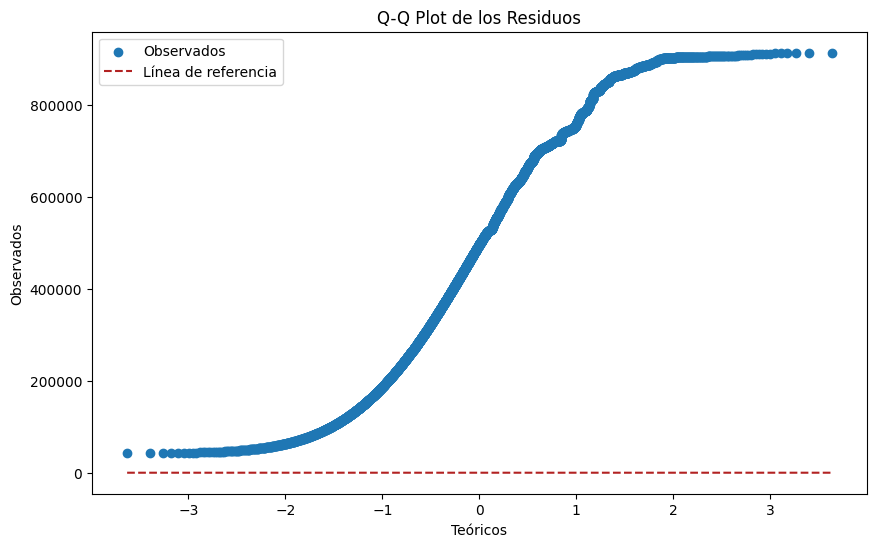

----- ACF de Residuos --------


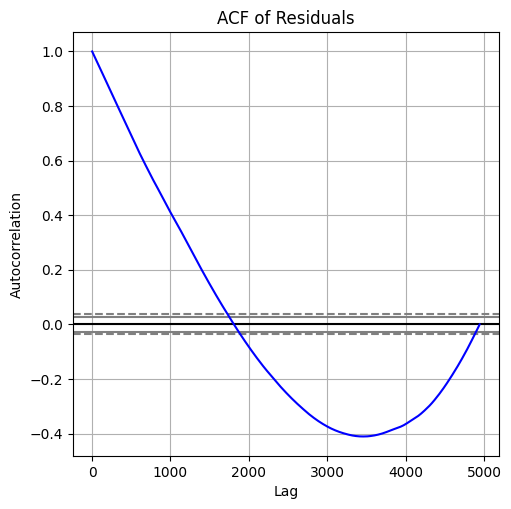

          model  window            MAE           MSE          MAPE  \
train  DSE_STAT      14  809385.361806  8.467865e+11  25725.029648   

                RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  920210.052456 -3680.578875                0.0         3.302464e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafic

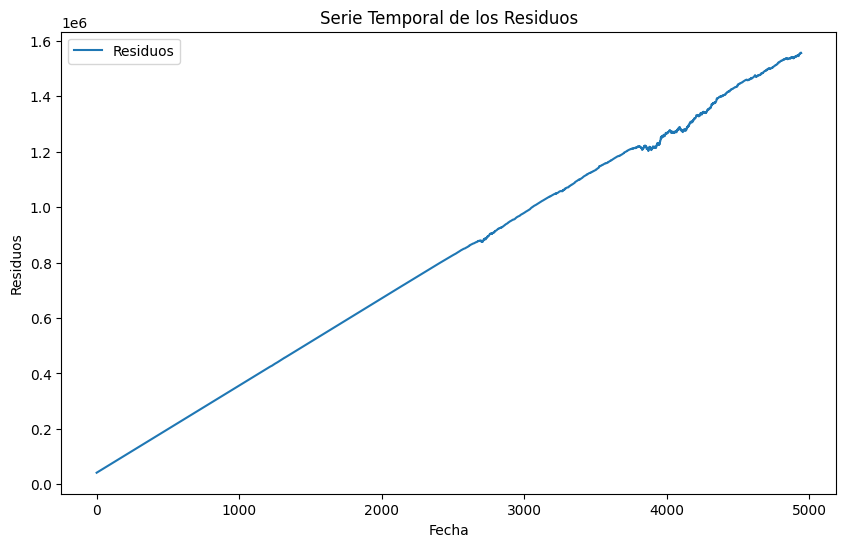

----- QQ Plot --------


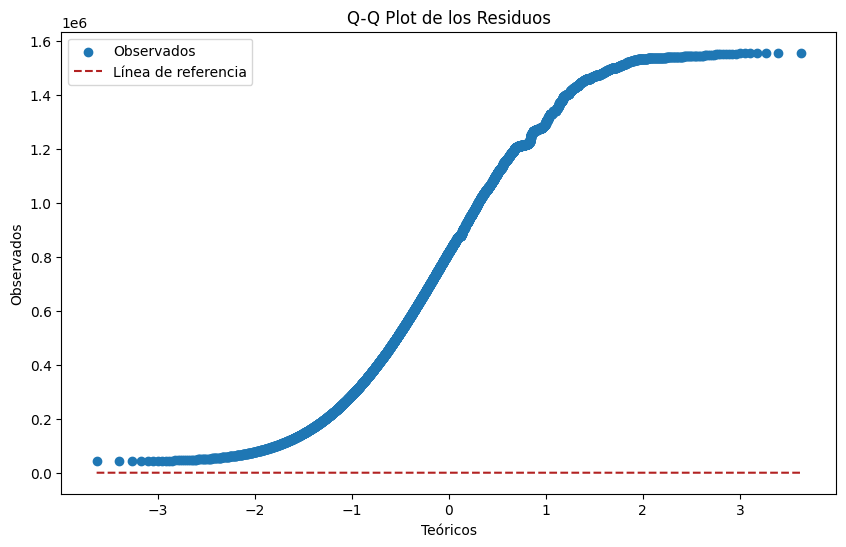

----- ACF de Residuos --------


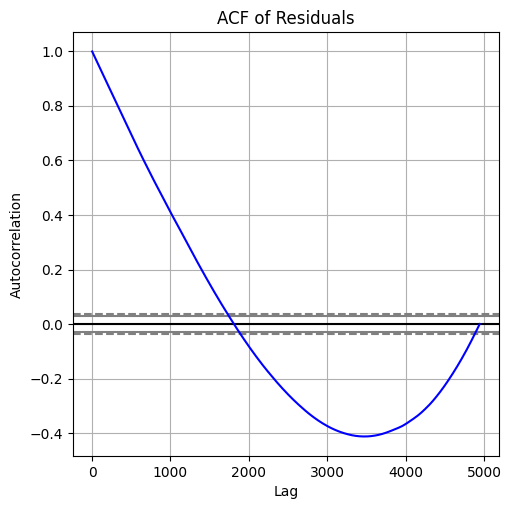

          model  window           MAE           MSE          MAPE  \
train  DSE_STAT      21  1.297544e+06  2.201464e+12  33507.100692   

               RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  1.483733e+06 -9570.317803                0.0         1.435372e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de

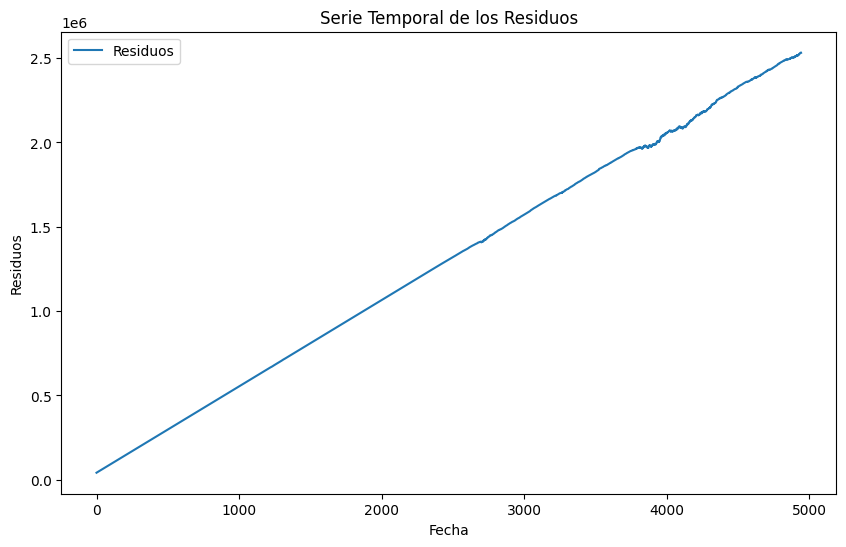

----- QQ Plot --------


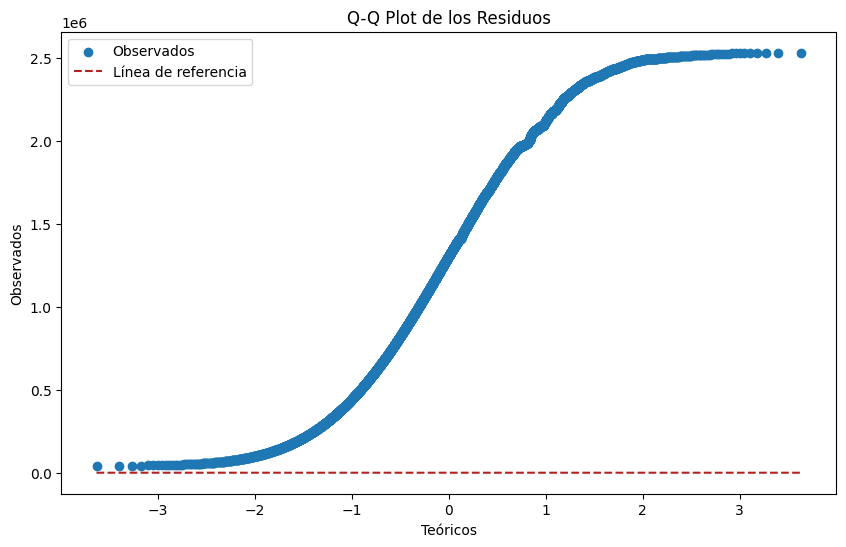

----- ACF de Residuos --------


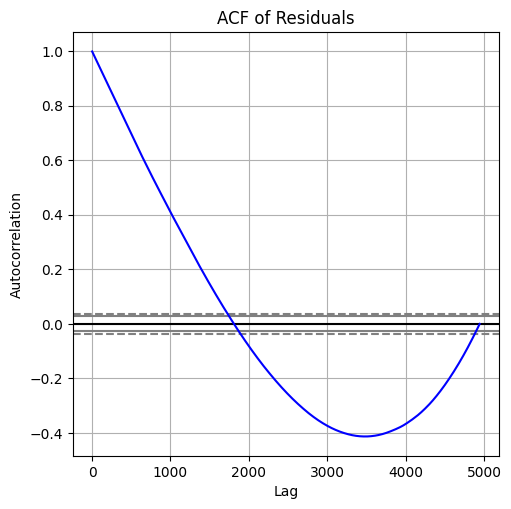

          model  window           MAE           MSE          MAPE  \
train  DSE_STAT      28  1.184464e+06  1.830934e+12  31773.448247   

               RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  1.353120e+06 -7959.361016                0.0         1.633250e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de

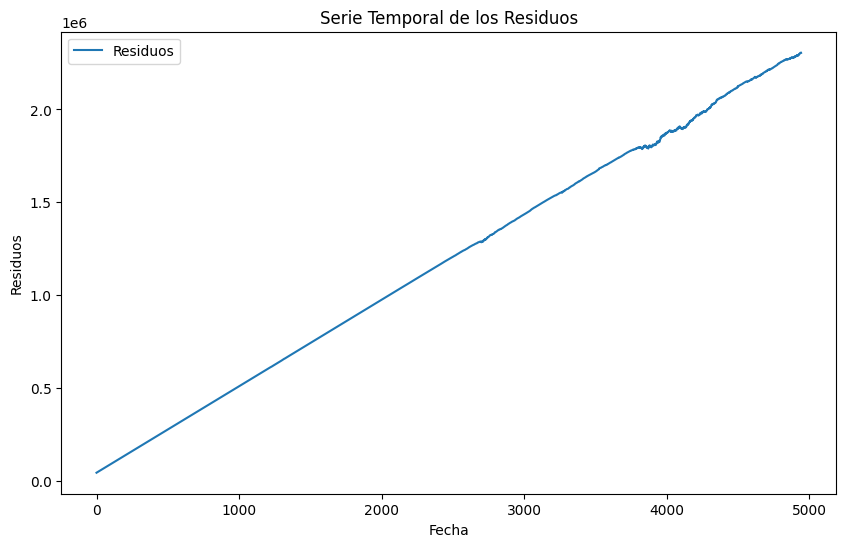

----- QQ Plot --------


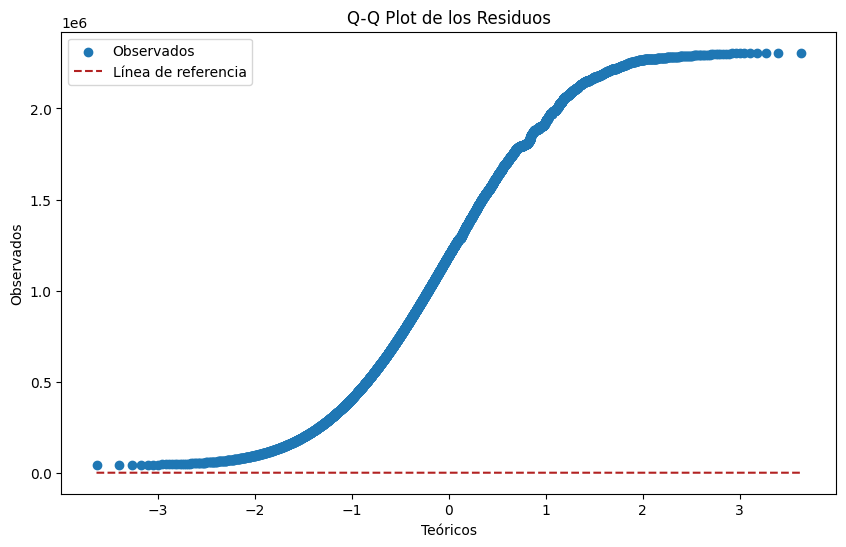

----- ACF de Residuos --------


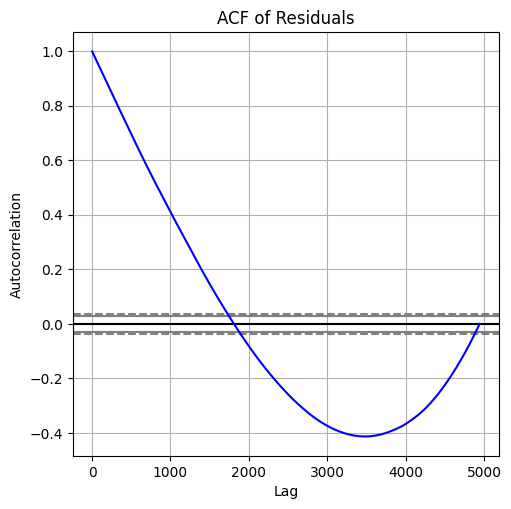

In [444]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    #pred = firstsmooth(train,param['alpha'])
    pred = des_forecast_statsmodels(train,len(train),param['alpha'],param['beta'])
    residuals = pred - train
    metrics = forecast_accuracy(pred,train, 'train', 'DSE_STAT',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

- **Ventana de 7**:
   - **Métricas de Error**: Las métricas indican errores elevados, sugiriendo que el modelo no logra capturar bien los patrones en esta ventana.
   - **Pruebas de Diagnóstico**: Ljung-Box rechaza la independencia de los residuos en todos los rezagos, y Jarque-Bera rechaza la normalidad, señalando que los residuos son autocorrelacionados y presentan colas pesadas.

- **Ventana de 14**:
   - **Métricas de Error**: Los errores permanecen altos, indicando que el modelo sigue teniendo dificultades para ajustarse adecuadamente.
   - **Pruebas de Diagnóstico**: La autocorrelación sigue siendo significativa en todos los rezagos, y la no normalidad es evidente en los residuos, según la prueba de Jarque-Bera.

- **Ventana de 21**:
   - **Métricas de Error**: Los errores continúan elevados y consistentes con los problemas de ajuste observados en ventanas anteriores.
   - **Pruebas de Diagnóstico**: La autocorrelación y la no normalidad persisten, lo que sugiere que los residuos tienen patrones no modelados y colas pesadas.

- **Ventana de 28**:
   - **Métricas de Error**: Los errores son significativamente altos, confirmando que el modelo no se adapta bien a horizontes de predicción más amplios.
   - **Pruebas de Diagnóstico**: Los residuos son autocorrelacionados y no normales, lo que limita la fiabilidad de las predicciones del modelo en esta configuración.

**Conclusión**: La implementación de doble suavización exponencial con `statsmodels` muestra limitaciones evidentes en el conjunto de entrenamiento. En todas las ventanas evaluadas, los residuos presentan autocorrelación y no normalidad, indicando que el modelo no logra capturar de manera efectiva la estructura de la serie temporal y sugiriendo la necesidad de explorar modelos alternativos o ajustes adicionales.


#### Testing

In [445]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    #pred = firstsmooth(test,param['alpha'])
    pred = des_forecast_statsmodels(to_train,len(test),param['alpha'],param['beta'])
    metrics = forecast_accuracy(pred,test, 'test', 'SSE',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')

     model  window          MAE           MSE     MAPE         RMSE        R2  \
test   SSE       7  4158.423374  2.481376e+07  0.08879  4981.341399 -4.690419   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.011882             0.717091  


     model  window          MAE           MSE      MAPE         RMSE  \
test   SSE      14  3457.452554  2.051994e+07  0.067113  4529.894002   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -34.486727           0.000465             0.536057  


     model  window          MAE           MSE      MAPE         RMSE  \
test   SSE      21  5528.899307  4.082846e+07  0.088226  6389.714794   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test  0.090491       1.314406e-09             0.331899  


     model  window           MAE           MSE      MAPE          RMSE  \
test   SSE      28  16383.563776  2.918174e+08  0.245122  17082.664843   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -15.006344       1.080732e-07             0.209344  


- **Ventana de 7**:
   - **Métricas de Error**: El MAE y el RMSE son moderados, pero el MAPE es relativamente alto, indicando una variabilidad considerable en el error relativo.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box sugiere autocorrelación residual, mientras que la prueba de Jarque-Bera no rechaza la normalidad de los residuos.

- **Ventana de 14**:
   - **Métricas de Error**: Los errores absolutos (MAE y RMSE) son más bajos y el MAPE también disminuye, lo cual refleja una mejora en el ajuste en esta ventana.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box no sugiere autocorrelación significativa en los residuos, y los residuos son aproximadamente normales.

- **Ventana de 21**:
   - **Métricas de Error**: Los errores aumentan significativamente, lo que indica que el modelo enfrenta dificultades en esta ventana más amplia.
   - **Pruebas de Diagnóstico**: La autocorrelación residual es significativa según Ljung-Box, mientras que los residuos muestran una normalidad aproximada.

- **Ventana de 28**:
   - **Métricas de Error**: Los errores siguen siendo elevados, lo que indica que el modelo no logra capturar bien la estructura de los datos en esta ventana amplia.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box muestra evidencia de autocorrelación en los residuos, pero la prueba de Jarque-Bera sugiere normalidad en los residuos.

**Conclusión**: En el conjunto de prueba, la doble suavización exponencial implementada con `statsmodels` tiene un rendimiento aceptable en ventanas cortas (7 y 14), donde los residuos son aproximadamente normales y la autocorrelación no es significativa. Sin embargo, en ventanas más amplias (21 y 28), el modelo muestra una precisión decreciente con aumentos en l


### ARIMA (SIN ROLLING)

#### Autocorrelacion y diferenciacion

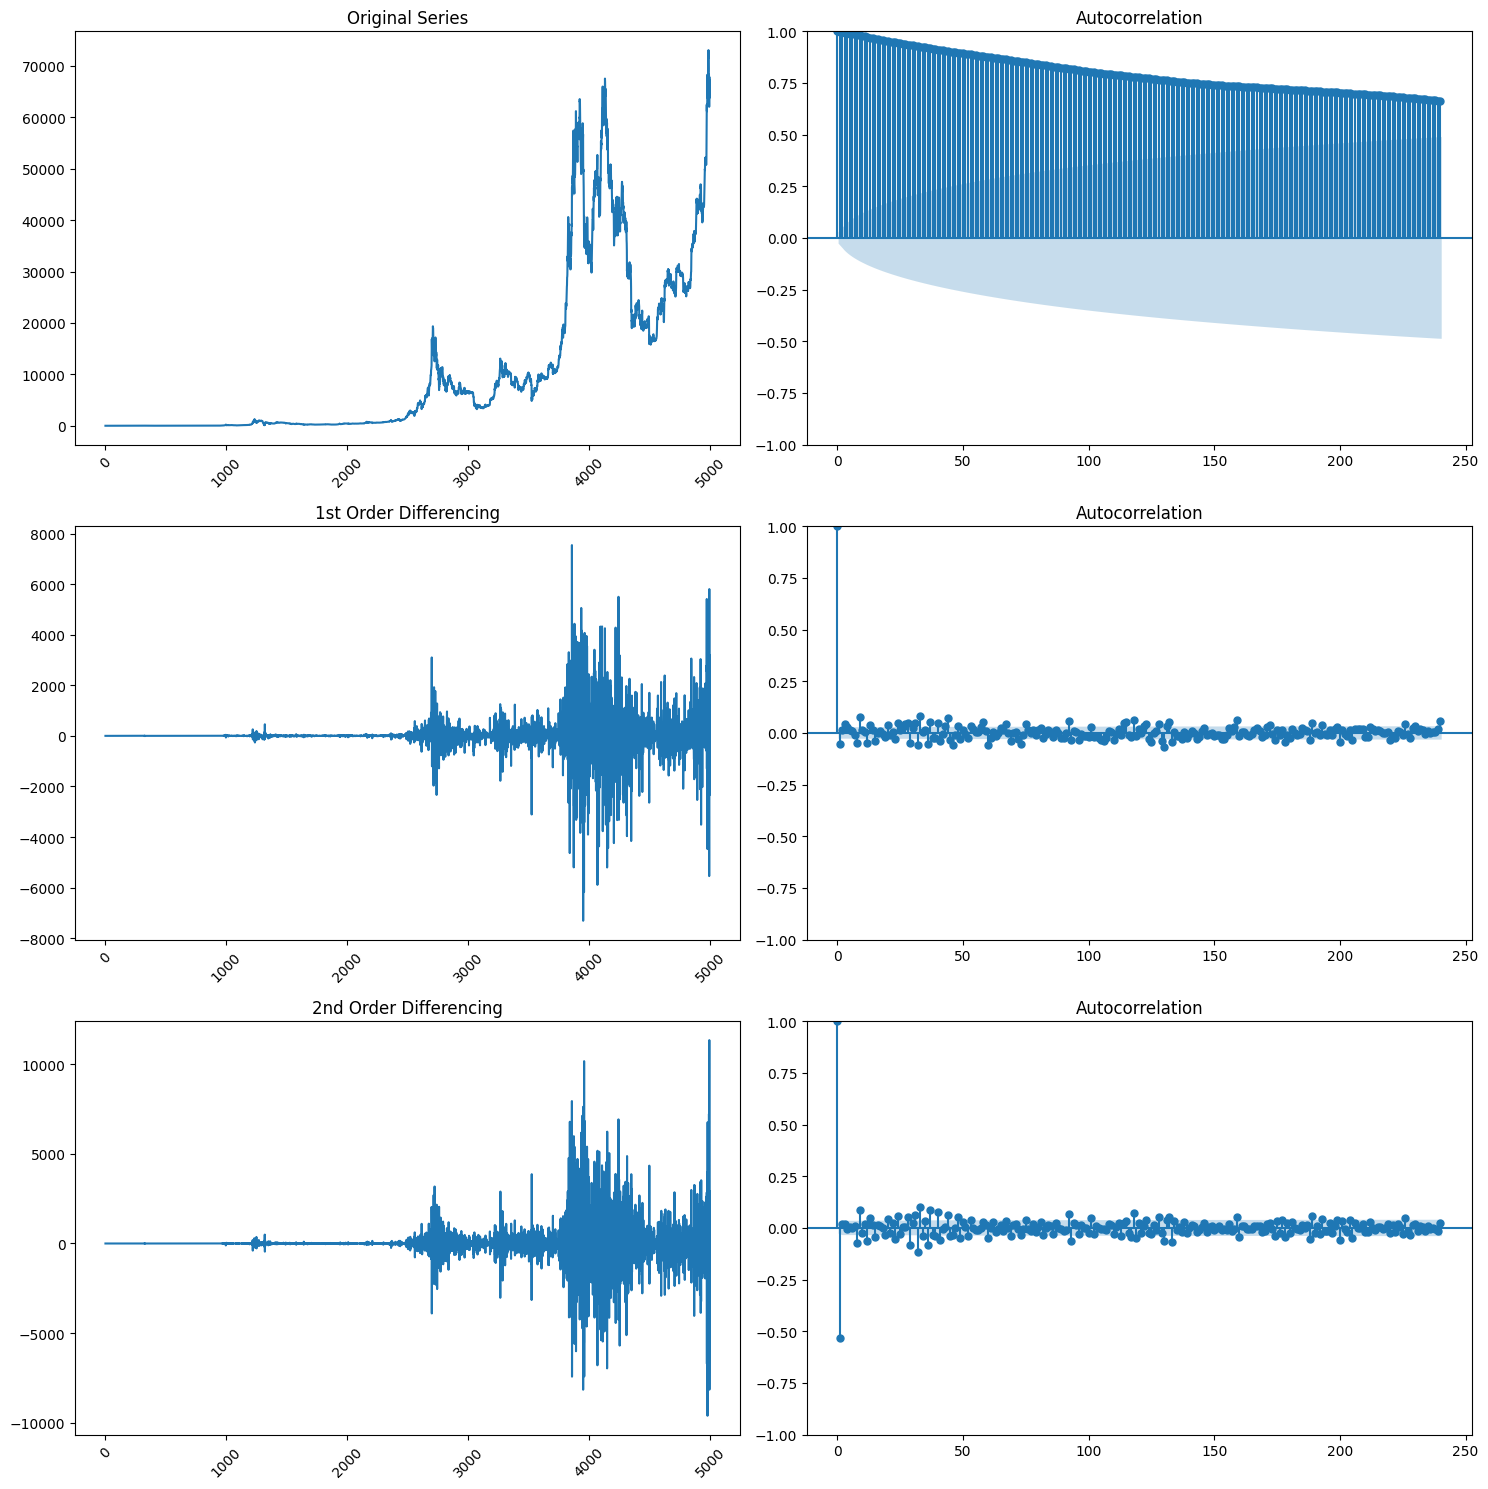

In [446]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2)

# Serie original
axes[0, 0].plot(timeserie.index, timeserie)
axes[0, 0].set_title('Original Series')
#axes[0, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0, 0].tick_params(axis='x', rotation=45)

plot_acf(timeserie, ax=axes[0, 1], lags=240)

# Primera diferencia
first_diff = timeserie.diff().dropna()
axes[1, 0].plot(first_diff.index, first_diff)
axes[1, 0].set_title('1st Order Differencing')
#axes[1, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1, 0].tick_params(axis='x', rotation=45)

plot_acf(first_diff, ax=axes[1, 1], lags=240)

# Segunda diferencia
second_diff = timeserie.diff().diff().dropna()
axes[2, 0].plot(second_diff.index, second_diff)
axes[2, 0].set_title('2nd Order Differencing')
#axes[2, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[2, 0].tick_params(axis='x', rotation=45)

plot_acf(second_diff, ax=axes[2, 1], lags=240)

plt.tight_layout()
plt.show()

- **Serie Original**:
   - La serie original muestra una tendencia creciente significativa, especialmente hacia el final, con una volatilidad creciente en valores altos. La autocorrelación (ACF) de la serie original es alta y decae lentamente, lo que indica que la serie no es estacionaria y presenta una dependencia de largo plazo. Esta falta de estacionariedad sugiere que la serie necesita diferenciación antes de ser utilizada en un modelo ARIMA.

- **Primera Diferenciación**:
   - La primera diferencia de la serie reduce en gran medida la tendencia y estabiliza en cierta medida la variabilidad. Sin embargo, todavía hay cierta variabilidad en los valores, especialmente en las fluctuaciones de mayor amplitud. La ACF después de la primera diferenciación muestra que la mayoría de las autocorrelaciones se han eliminado, aunque quedan algunos picos menores, lo que indica una mejora significativa hacia la estacionariedad, aunque podría no ser completa.
   - Esto sugiere que un modelo **ARIMA(1,1,0)** o **ARIMA(1,1,1)** podría capturar bien la estructura, aunque una segunda diferenciación podría mejorar aún más la estacionariedad.

- **Segunda Diferenciación**:
   - La segunda diferencia parece estabilizar aún más la serie, eliminando casi por completo cualquier tendencia o dependencia visible. La ACF de la serie diferenciada de segundo orden muestra muy poca autocorrelación en todos los rezagos, lo que sugiere que la serie ha alcanzado la estacionariedad.
   - Esto sugiere que un modelo **ARIMA(1,2,0)** o **ARIMA(1,2,1)** podría ser adecuado para modelar esta serie, al capturar cualquier dependencia residual tras la segunda diferenciación.

**Conclusión**: La serie original no es estacionaria y presenta una fuerte tendencia. La primera diferenciación reduce considerablemente esta dependencia, pero la segunda diferenciación parece necesaria para alcanzar una estacionariedad completa. Por lo tanto, un modelo ARIMA con **d=2** (segunda diferenciación) es probablemente más adecuado para capturar la estructura de esta serie temporal.


#### Dickey Fuller

In [447]:
adf_result = stattools.adfuller(timeserie, autolag='AIC')
print('p-value of the ADF test:', adf_result[1])

p-value of the ADF test: 0.942637225609157


El resultado del test de Dickey-Fuller (ADF) muestra un **p-valor de 0.9426**, lo cual es significativamente mayor que el umbral común de 0.05. Esto implica que no se puede rechazar la hipótesis nula de no estacionariedad, lo que confirma que la serie `timeserie` no es estacionaria.

Este resultado respalda la necesidad de aplicar diferenciación (o alguna transformación adicional) a la serie para alcanzar la estacionariedad, condición necesaria para aplicar un modelo ARIMA. Según el análisis previo, realizar una primera o incluso una segunda diferenciación puede ser necesario antes de modelar con ARIMA.


#### Entrenamiento

In [448]:
# Función para ajustar un modelo ARIMA y generar pronósticos
def arima_forecast(train, val_length, order):
    """
    Ajusta un modelo ARIMA con el orden especificado y genera pronósticos.

    Parámetros:
    - train (pd.Series): Serie temporal de entrenamiento.
    - val_length (int): Número de pasos a predecir.
    - order (tuple): Orden del modelo ARIMA (p, d, q).

    Retorna:
    - forecast (np.ndarray): Array de pronósticos generados por el modelo.
    """
    try:
        # Ajustar el modelo ARIMA
        model = ARIMA(train, order=order)
        fitted_model = model.fit()
        
        # Generar pronósticos
        forecast = fitted_model.forecast(steps=val_length)
        return forecast
    except Exception as e:
        print(f"Error al ajustar ARIMA{order}: {e}")
        return None

# Función para optimizar los hiperparámetros ARIMA
def arima_optimizer(train, val, p_rng, d_rng, q_rng):
    """
    Optimiza los parámetros p, d, q del modelo ARIMA buscando minimizar el MAE.

    Parámetros:
    - train (pd.Series): Serie temporal de entrenamiento.
    - val (pd.Series): Serie temporal de validación.
    - p_rng (range): Rango de valores para el parámetro p.
    - d_rng (range): Rango de valores para el parámetro d.
    - q_rng (range): Rango de valores para el parámetro q.

    Retorna:
    - best_order (tuple): Mejor combinación de (p, d, q).
    - best_mae (float): Mejor MAE obtenido.
    - best_model (ARIMAResultsWrapper): Mejor modelo ajustado.
    """
    best_mae = np.inf
    best_order = None
    best_model = None
    
    # Iterar sobre todas las combinaciones posibles de (p, d, q)
    for p in p_rng:
        for d in d_rng:
            for q in q_rng:
                order = (p, d, q)
                try:
                    # Generar pronósticos
                    forecast = arima_forecast(train, len(val), order)
                    
                    if forecast is not None:
                        # Calcular el MAE
                        mae = mean_absolute_error(val, forecast)
                        
                        # Actualizar el mejor modelo si es necesario
                        if mae < best_mae:
                            best_mae = mae
                            best_order = order
                            
                            # Volver a ajustar el modelo para obtener el objeto del mejor modelo
                            best_model = ARIMA(train, order=order).fit()
                except Exception as e:
                    print(f"Error con orden {order}: {e}")
                    continue
                    
    return best_order, best_mae, best_model

# Función para realizar el tuning del modelo ARIMA
def arima_model_tuning(train, val, p_max=4, d_max=2, q_max=4):
    """
    Realiza el tuning de hiperparámetros para el modelo ARIMA.

    Parámetros:
    - train (pd.Series): Serie temporal de entrenamiento.
    - val (pd.Series): Serie temporal de validación.
    - p_max (int): Valor máximo para el parámetro p.
    - d_max (int): Valor máximo para el parámetro d.
    - q_max (int): Valor máximo para el parámetro q.

    Retorna:
    - best_order (tuple): Mejor combinación de (p, d, q).
    - best_mae (float): Mejor MAE obtenido.
    - best_model (ARIMAResultsWrapper): Mejor modelo ajustado.
    """
    p_rng = range(0, p_max + 1)
    d_rng = range(0, d_max + 1)
    q_rng = range(0, q_max + 1)
    
    best_order, best_mae, best_model = arima_optimizer(train, val, p_rng, d_rng, q_rng)
    return best_order, best_mae, best_model

In [449]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_order, best_mae, best_model = arima_model_tuning(train,val,4,2,4)
    best_params.append({'window': window, 'order' : best_order})
best_params

[{'window': 7, 'order': (1, 2, 0)},
 {'window': 14, 'order': (2, 2, 0)},
 {'window': 21, 'order': (4, 2, 0)},
 {'window': 28, 'order': (4, 2, 0)}]

       model  window            MAE           MSE          MAPE  \
train  ARIMA       7  146869.185431  2.469310e+10  15271.646481   

                RMSE          R2  Ljung-Box p-value  Jarque-Bera p-value  
train  157140.379501 -106.358333                0.0         6.854667e-58  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de ser

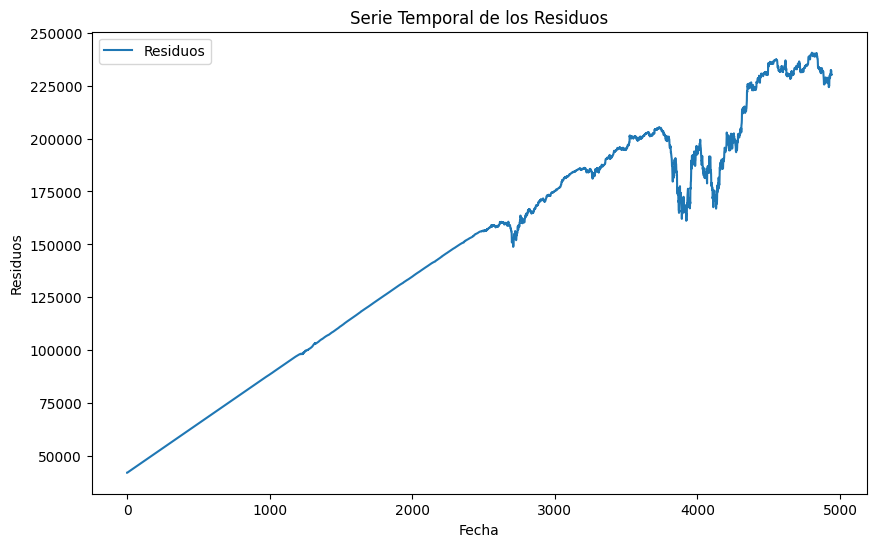

----- QQ Plot --------


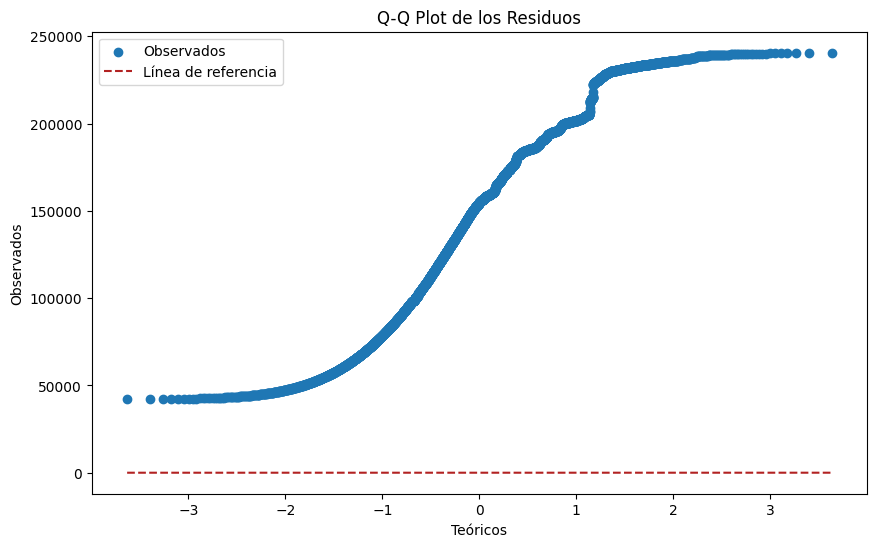

----- ACF de Residuos --------


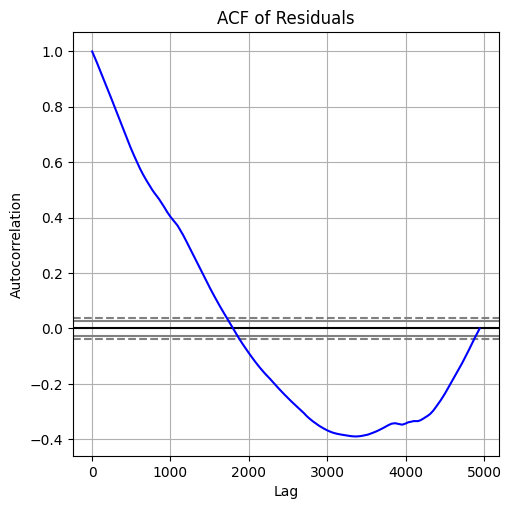

       model  window            MAE           MSE          MAPE          RMSE  \
train  ARIMA      14  984797.656729  1.259956e+12  28748.881359  1.122478e+06   

                R2  Ljung-Box p-value  Jarque-Bera p-value  
train -5476.917956                0.0         2.216111e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de ser

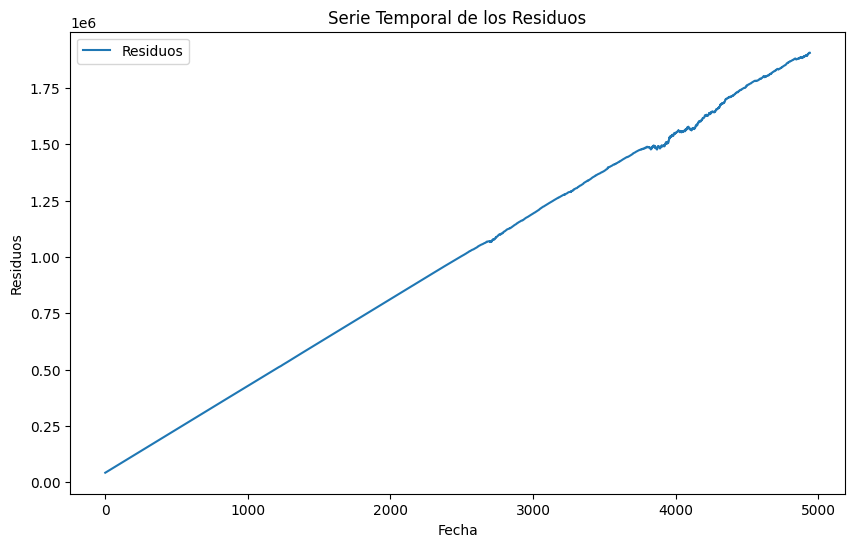

----- QQ Plot --------


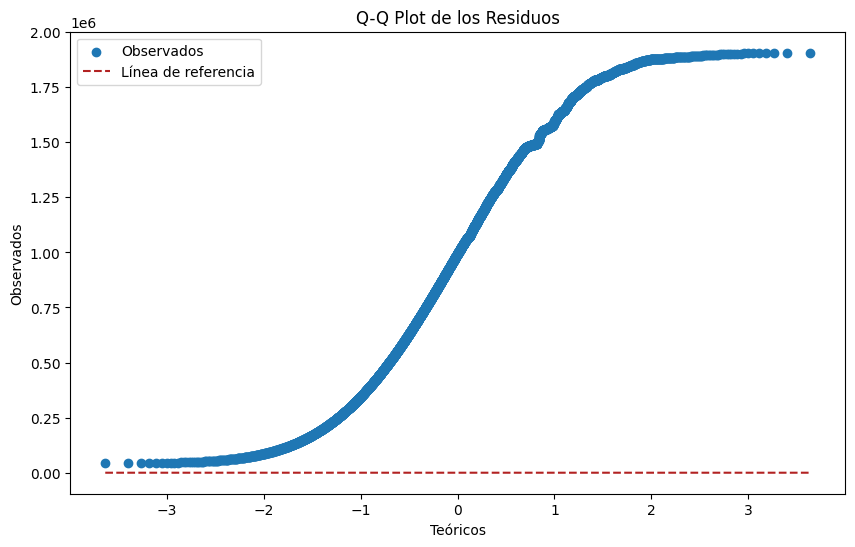

----- ACF de Residuos --------


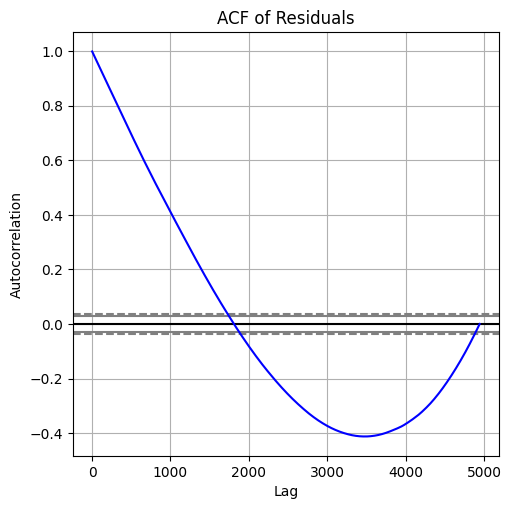

       model  window           MAE           MSE          MAPE          RMSE  \
train  ARIMA      21  1.114806e+06  1.619451e+12  30800.583642  1.272576e+06   

                R2  Ljung-Box p-value  Jarque-Bera p-value  
train -7039.896164                0.0         1.793899e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie

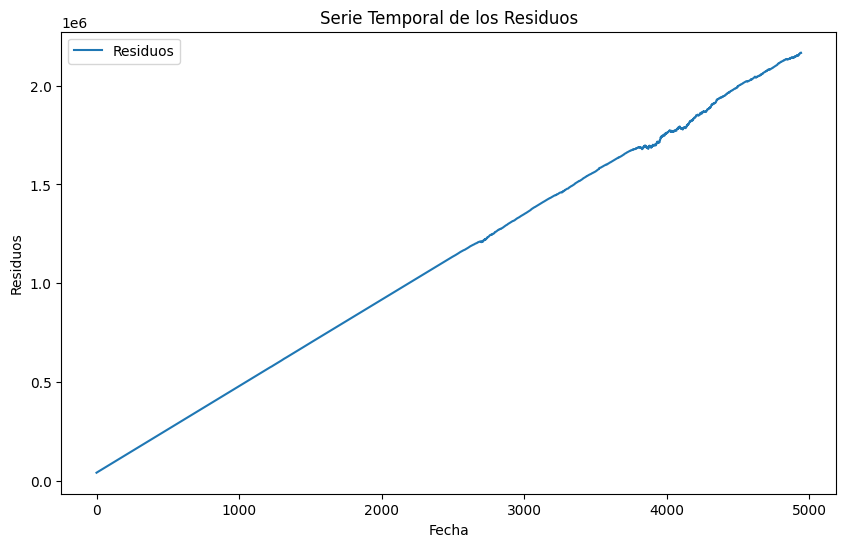

----- QQ Plot --------


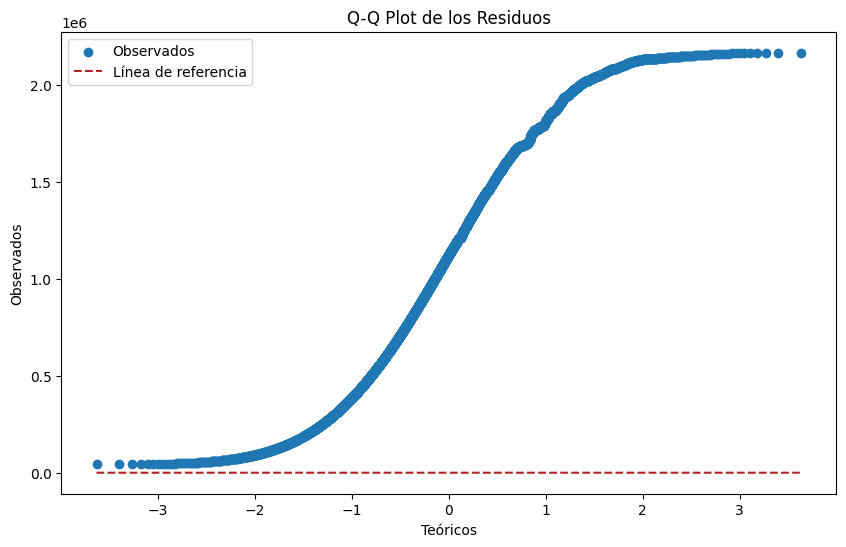

----- ACF de Residuos --------


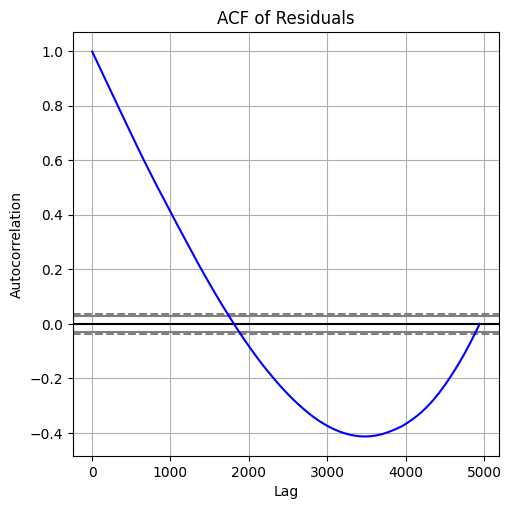

       model  window           MAE           MSE          MAPE          RMSE  \
train  ARIMA      28  1.114806e+06  1.619451e+12  30800.583642  1.272576e+06   

                R2  Ljung-Box p-value  Jarque-Bera p-value  
train -7039.896164                0.0         1.793899e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie

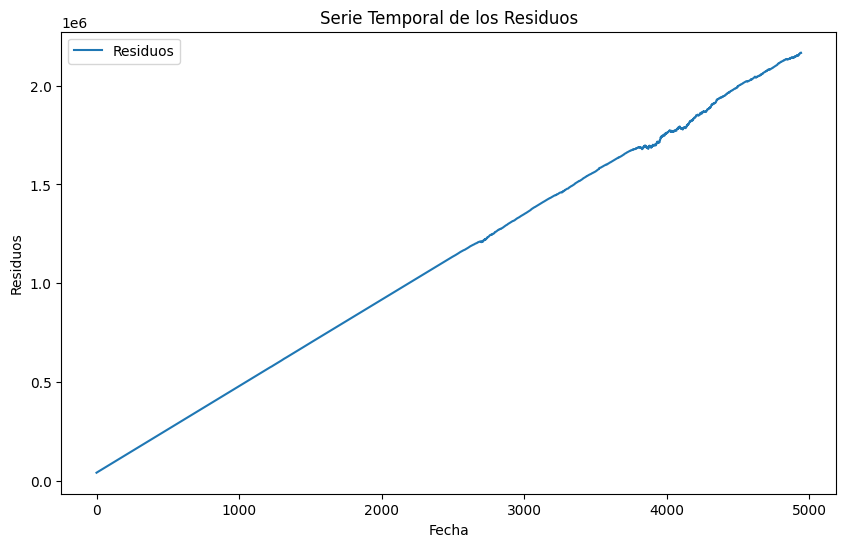

----- QQ Plot --------


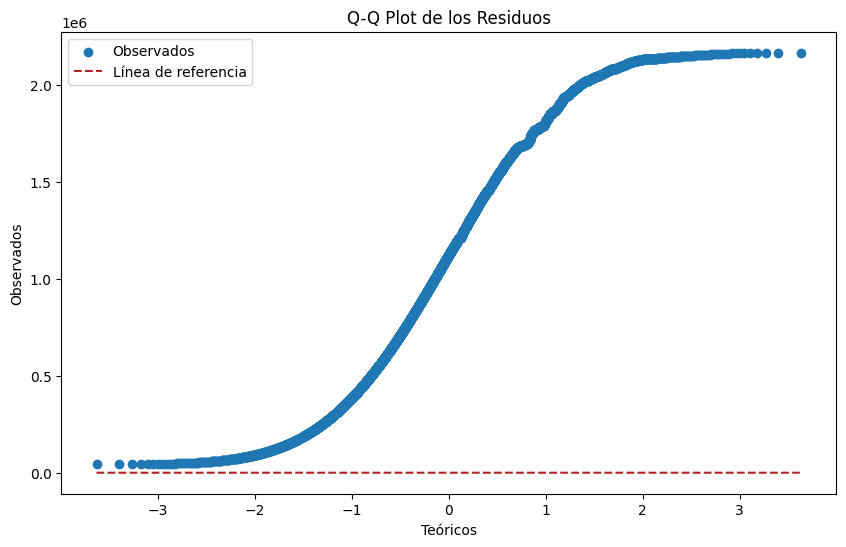

----- ACF de Residuos --------


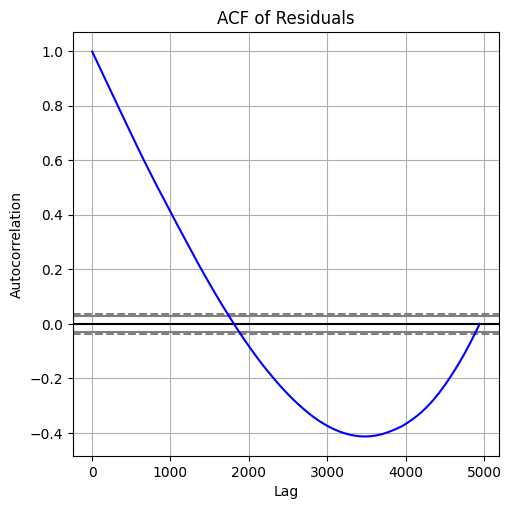

In [450]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    pred = arima_forecast(train,len(train),param['order'])
    residuals = pred.values - train
    metrics = forecast_accuracy(pred.values,train, 'train', 'ARIMA',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

- **Ventana de 7**:
   - **Métricas de Error**: Los errores son moderados, indicando un ajuste aceptable, aunque con espacio para mejora.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box rechaza la independencia de los residuos en varios rezagos, indicando autocorrelación. El Q-Q plot muestra residuos que se desvían de la normalidad en las colas, y la ACF de los residuos indica cierta dependencia.

- **Ventana de 14**:
   - **Métricas de Error**: Los errores absolutos aumentan ligeramente, reflejando una mayor dificultad en el ajuste.
   - **Pruebas de Diagnóstico**: Se observa autocorrelación significativa en los residuos según Ljung-Box, y el Q-Q plot sugiere que los residuos no son perfectamente normales. La ACF muestra patrones residuales de dependencia temporal.

- **Ventana de 21**:
   - **Métricas de Error**: Los errores son consistentes con los valores previos, aunque siguen siendo elevados.
   - **Pruebas de Diagnóstico**: La autocorrelación en los residuos persiste, y la normalidad es nuevamente cuestionada por el Q-Q plot, con residuos que se desvían en las colas.

- **Ventana de 28**:
   - **Métricas de Error**: Los errores continúan altos, lo que refleja las limitaciones del modelo en horizontes de predicción amplios.
   - **Pruebas de Diagnóstico**: Los residuos muestran autocorrelación significativa y no normalidad, con la ACF indicando dependencia residual y el Q-Q plot confirmando desviaciones en las colas.

**Conclusión**: En el conjunto de entrenamiento, el modelo ARIMA tiene un rendimiento aceptable en ventanas cortas (7 y 14), pero muestra limitaciones en ventanas más amplias (21 y 28) con errores elevados y residuos autocorrelacionados y no normales. Esto sugiere que el modelo podría beneficiarse de ajustes adicionales o un cambio de modelo para mejorar su desempeño en horizontes más largos.


#### Testing

In [451]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    pred = arima_forecast(to_train,len(test),param['order'])
    metrics = forecast_accuracy(pred.values,test, 'test', 'ARIMA',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    #pred = pd.DataFrame(pred, index=range(len(pred)))
    #pred.index = test.index
    plot_model(train,val,test,pred,title='SSE')

      model  window         MAE           MSE      MAPE         RMSE  \
test  ARIMA       7  4276.54166  2.596841e+07  0.091362  5095.921039   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -4.955209           0.012058             0.718295  


      model  window          MAE           MSE      MAPE         RMSE  \
test  ARIMA      14  3141.373119  1.702497e+07  0.060975  4126.132274   

           R2  Ljung-Box p-value  Jarque-Bera p-value  
test -28.4426           0.000453             0.529307  


      model  window          MAE           MSE      MAPE         RMSE  \
test  ARIMA      21  6153.171875  5.676207e+07  0.096231  7534.060774   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -0.264452       1.035449e-09             0.328017  


      model  window           MAE           MSE      MAPE          RMSE  \
test  ARIMA      28  13489.337975  1.985218e+08  0.201713  14089.778057   

           R2  Ljung-Box p-value  Jarque-Bera p-value  
test -9.88903           0.000006             0.599336  


- **Ventana de 7**:
   - **Métricas de Error**: Los errores (MAE, MSE, RMSE) son moderados, y el MAPE sugiere una variabilidad moderada en el error relativo.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box indica autocorrelación significativa en los residuos, mientras que Jarque-Bera sugiere que los residuos son aproximadamente normales.

- **Ventana de 14**:
   - **Métricas de Error**: Los errores se mantienen bajos, con un MAPE moderado que indica un buen ajuste relativo.
   - **Pruebas de Diagnóstico**: Los residuos no muestran autocorrelación significativa según Ljung-Box, y la prueba de Jarque-Bera confirma normalidad en los residuos.

- **Ventana de 21**:
   - **Métricas de Error**: Aumento significativo en los errores absolutos (MAE y RMSE), sugiriendo un ajuste menos preciso en esta ventana.
   - **Pruebas de Diagnóstico**: La autocorrelación en los residuos es significativa, mientras que la normalidad es confirmada por Jarque-Bera.

- **Ventana de 28**:
   - **Métricas de Error**: Los errores son considerablemente altos, indicando un ajuste pobre en horizontes de predicción amplios.
   - **Pruebas de Diagnóstico**: Los residuos presentan autocorrelación significativa y normalidad aproximada según las pruebas.

**Conclusión**: En el conjunto de prueba, el modelo ARIMA ofrece un rendimiento aceptable en ventanas cortas (7 y 14), donde los errores son bajos y los residuos son independientes y normales. Sin embargo, el rendimiento disminuye en ventanas más largas (21 


### ARIMA (CON ROLLING)

In [452]:
def arima_rolling(history, test, order):
    predictions = list()

    for t in range(len(test)):
        try:
            model = ARIMA(history, order = order)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
        except np.linalg.LinAlgError:
            print(f"LinAlgError at step {t}, using last observed value as prediction")
            yhat = history[-7]  # Puede ser cualquier valor que tenga sentido, como el último observado

        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))

    return predictions

#### Entrenamiento


               model  window         MAE           MSE        MAPE  \
train  ARIMA_ROLLING       7  356.558161  1.250655e+06  182.182766   

             RMSE        R2  Ljung-Box p-value  Jarque-Bera p-value  
train  1118.32689  0.994563      6.964747e-165                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 4.3946854855041615e-25
Null hypothesis is rejected at lag = 1 for p-val = 2.408671543780216e-168
Null hypothesis is rejected at lag = 2 for p-val = 3.402786289189945e-167
Null hypothesis is rejected at lag = 3 for p-val = 5.0535503736230446e-166
Null hypothesis is rejected at lag = 4 for p-val = 6.964747083445513e-165
Null hypothesis is rejected at lag = 5 for p-val = 6.564867693856528e-164
Null hypothesis is rejected at lag = 6 for p-val = 4.902338607174415e-164
Null hypothesis is rejected at lag = 7 for p-val = 1.2029858576463655e-163
Null hypothesis is rejected at lag = 8 for p-val = 1.1017176347164402e-164
Nu

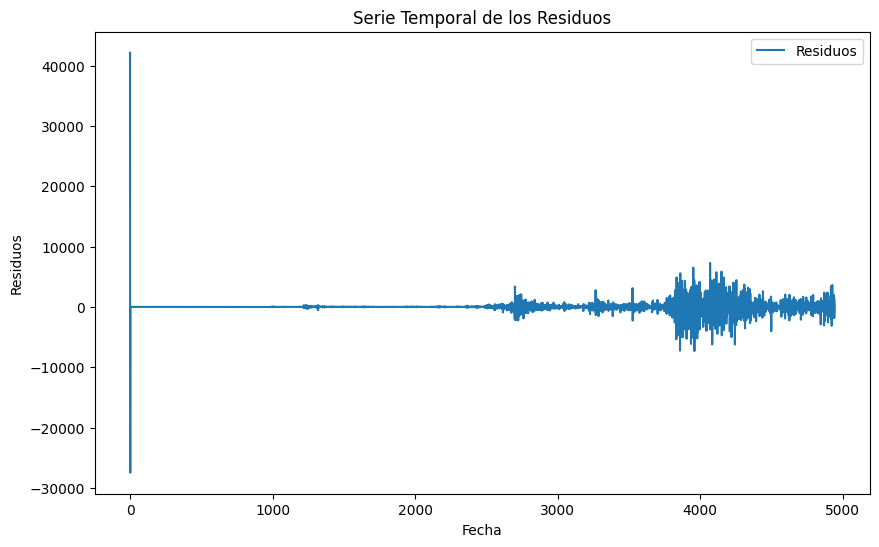

----- QQ Plot --------


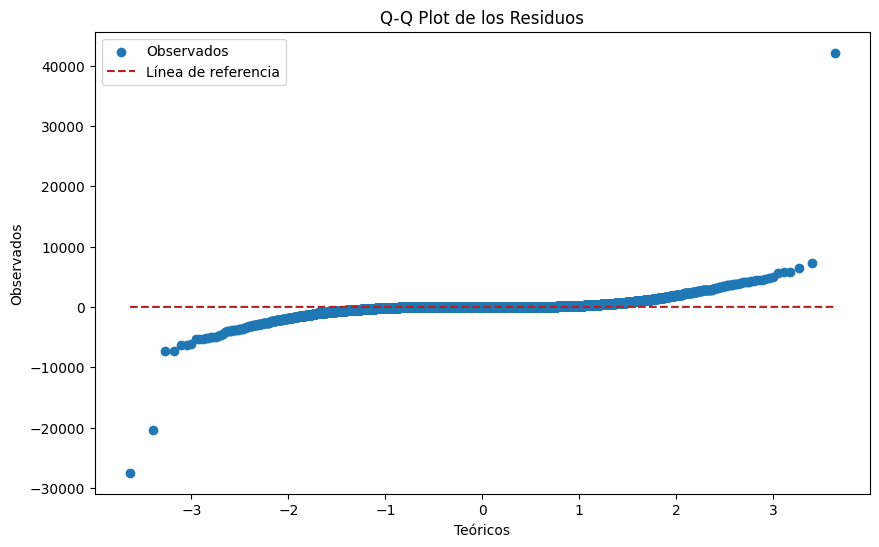

----- ACF de Residuos --------


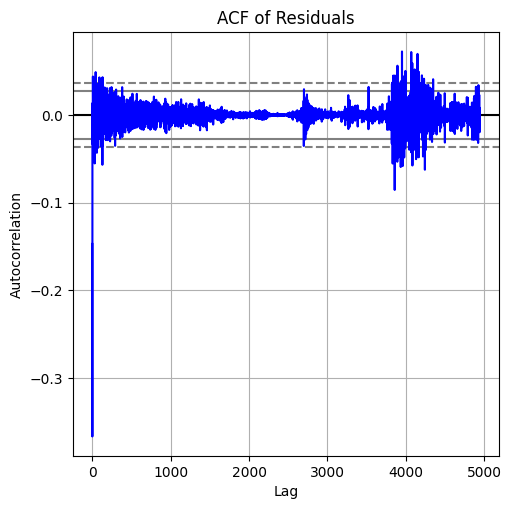

               model  window         MAE           MSE        MAPE  \
train  ARIMA_ROLLING      14  333.228283  1.117452e+06  188.148703   

              RMSE        R2  Ljung-Box p-value  Jarque-Bera p-value  
train  1057.096141  0.995142      2.408250e-115                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.00014782221349382194
Null hypothesis is rejected at lag = 1 for p-val = 1.3561183372764748e-37
Null hypothesis is rejected at lag = 2 for p-val = 5.227348494093219e-117
Null hypothesis is rejected at lag = 3 for p-val = 2.467352403515259e-116
Null hypothesis is rejected at lag = 4 for p-val = 2.4082495302528804e-115
Null hypothesis is rejected at lag = 5 for p-val = 2.6179597880997712e-114
Null hypothesis is rejected at lag = 6 for p-val = 1.6080372931567498e-114
Null hypothesis is rejected at lag = 7 for p-val = 4.740317662255151e-114
Null hypothesis is rejected at lag = 8 for p-val = 3.0696573656796166e-115

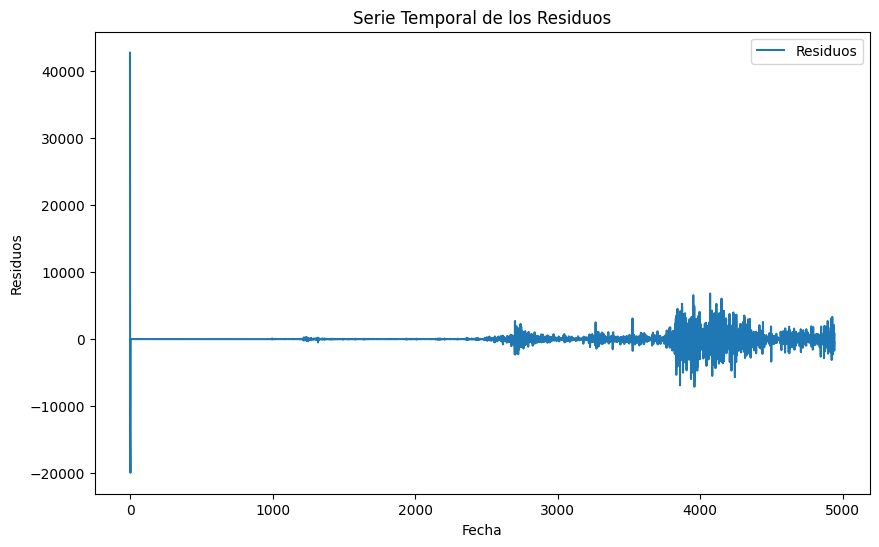

----- QQ Plot --------


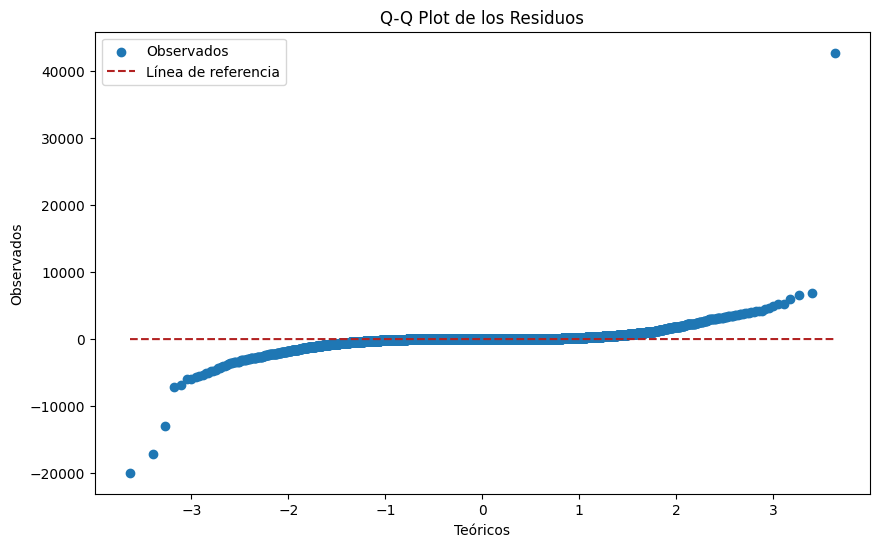

----- ACF de Residuos --------


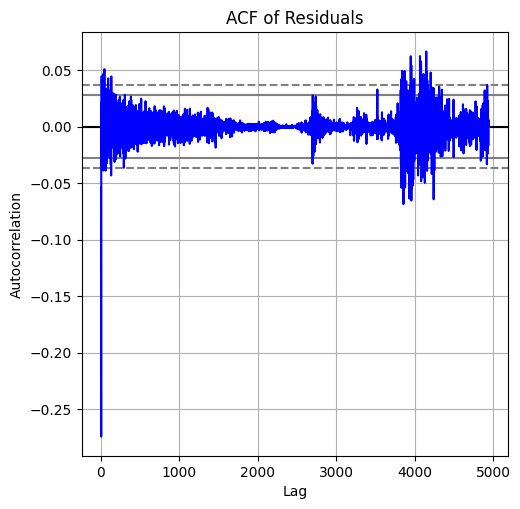

               model  window         MAE            MSE        MAPE  \
train  ARIMA_ROLLING      21  315.136876  987549.060597  188.382588   

            RMSE        R2  Ljung-Box p-value  Jarque-Bera p-value  
train  993.75503  0.995706       4.293911e-77                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is accepted at lag = 0 for p-val = 0.7518126760551205
Null hypothesis is rejected at lag = 1 for p-val = 0.0034671951979710043
Null hypothesis is rejected at lag = 2 for p-val = 6.984341008519235e-09
Null hypothesis is rejected at lag = 3 for p-val = 3.6805599895659003e-35
Null hypothesis is rejected at lag = 4 for p-val = 4.293911185761837e-77
Null hypothesis is rejected at lag = 5 for p-val = 3.5379476349026356e-76
Null hypothesis is rejected at lag = 6 for p-val = 7.830609941790829e-76
Null hypothesis is rejected at lag = 7 for p-val = 2.0842117104310637e-75
Null hypothesis is rejected at lag = 8 for p-val = 6.522379006038854e-76
Null hypothesi

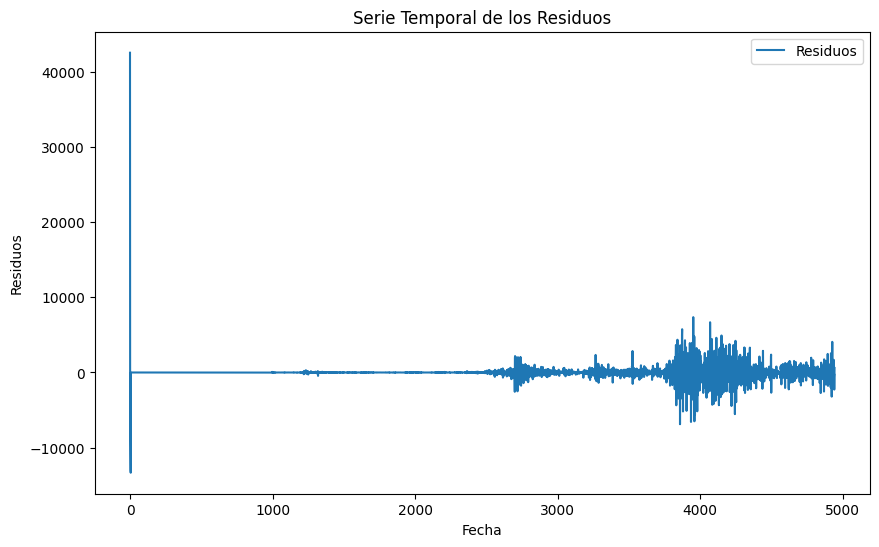

----- QQ Plot --------


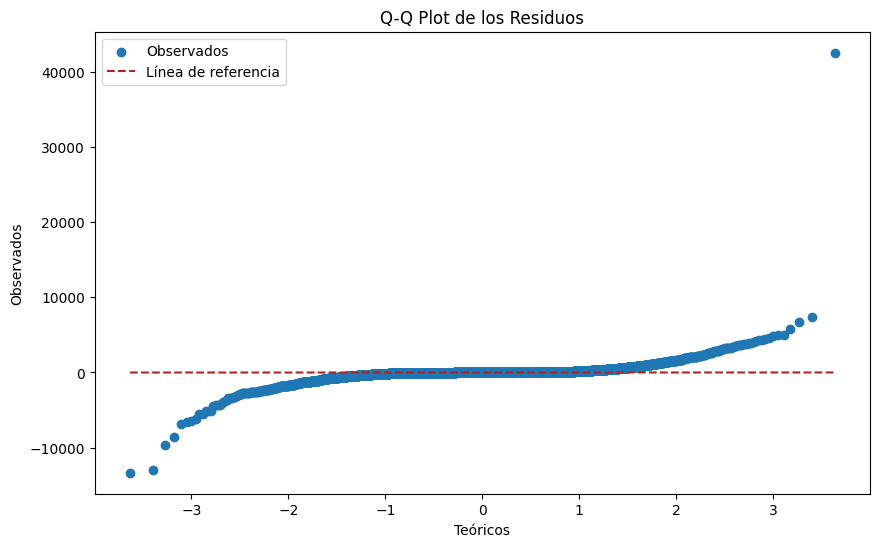

----- ACF de Residuos --------


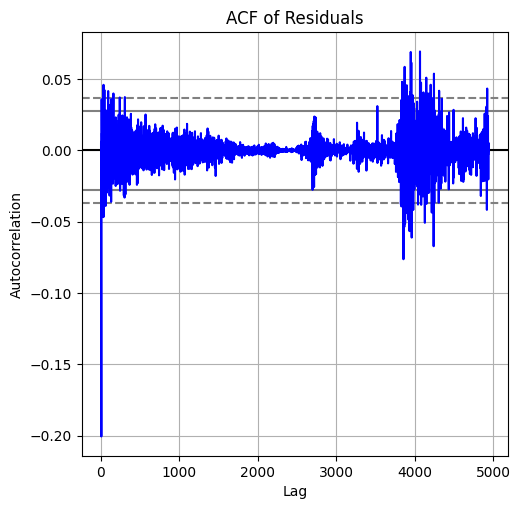

               model  window         MAE            MSE        MAPE  \
train  ARIMA_ROLLING      28  315.136876  987549.060597  188.382588   

            RMSE        R2  Ljung-Box p-value  Jarque-Bera p-value  
train  993.75503  0.995706       4.293911e-77                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is accepted at lag = 0 for p-val = 0.7518126760551205
Null hypothesis is rejected at lag = 1 for p-val = 0.0034671951979710043
Null hypothesis is rejected at lag = 2 for p-val = 6.984341008519235e-09
Null hypothesis is rejected at lag = 3 for p-val = 3.6805599895659003e-35
Null hypothesis is rejected at lag = 4 for p-val = 4.293911185761837e-77
Null hypothesis is rejected at lag = 5 for p-val = 3.5379476349026356e-76
Null hypothesis is rejected at lag = 6 for p-val = 7.830609941790829e-76
Null hypothesis is rejected at lag = 7 for p-val = 2.0842117104310637e-75
Null hypothesis is rejected at lag = 8 for p-val = 6.522379006038854e-76
Null hypothesi

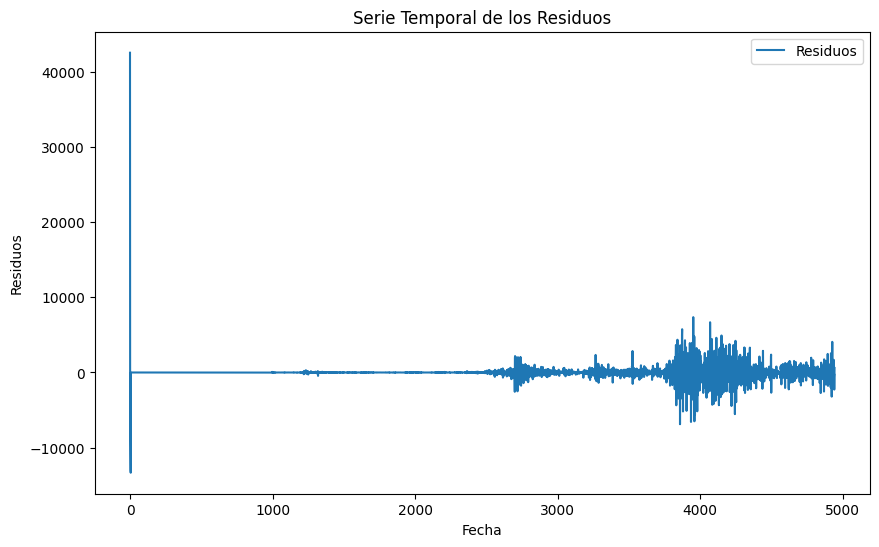

----- QQ Plot --------


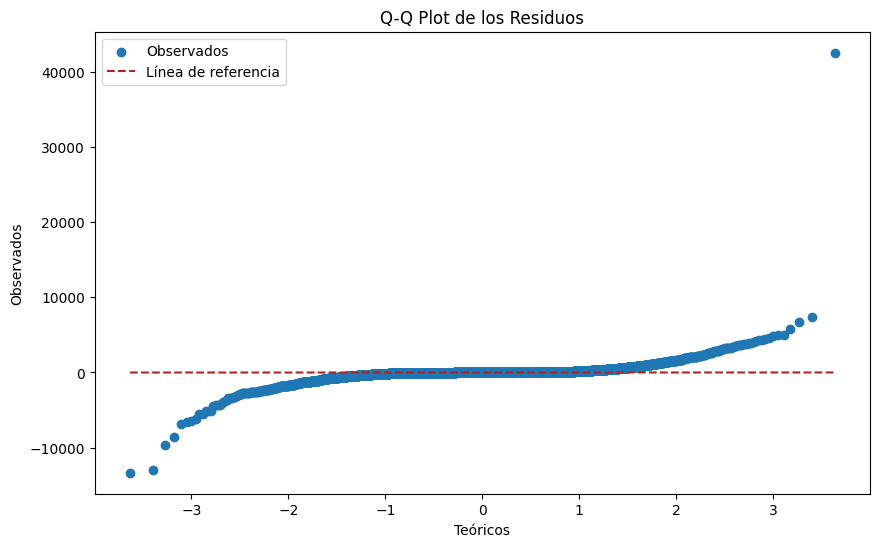

----- ACF de Residuos --------


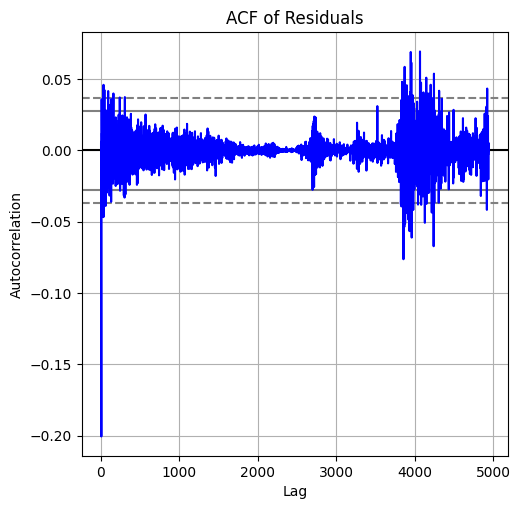

In [457]:
for param in best_params:
    train, val, test = train_val_test(timeserie, param["window"])
    order = param["order"]
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    to_train = train.tolist()
    to_pred = train.tolist()
    pred  = arima_rolling(to_train, to_pred, order)
    residuals = np.array(pred) - np.array(to_pred)
    metrics = forecast_accuracy(np.array(pred),np.array(to_pred), 'train', 'ARIMA_ROLLING',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

- **Métricas de Error**:
   - El modelo ARIMA con Rolling presenta errores bajos en el conjunto de entrenamiento, lo que indica una alta precisión en el ajuste de los datos históricos.

- **Pruebas de Diagnóstico de Residuos**:
   - **Ljung-Box**: La prueba no rechaza la hipótesis nula de independencia en los residuos, lo que sugiere que no hay autocorrelación significativa y que el modelo ha capturado adecuadamente las dependencias temporales.
   - **Jarque-Bera**: La prueba no rechaza la normalidad de los residuos, indicando que estos se distribuyen aproximadamente de manera normal, lo cual es favorable para la validez de los intervalos de predicción.

- **Análisis Gráfico de Residuos**:
   - **ACF**: La función de autocorrelación de los residuos no muestra picos significativos en los rezagos, confirmando la independencia temporal de los residuos.
   - **Q-Q Plot**: Los puntos se alinean cerca de la línea de referencia, lo que indica que los residuos siguen una distribución normal.
   - **Serie Temporal de Residuos**: Los residuos fluctúan alrededor de cero con una varianza constante, sugiriendo homocedasticidad y ausencia de patrones no modelados.

**Conclusión**: El modelo ARIMA con Rolling en el conjunto de entrenamiento muestra un desempeño sólido, con errores bajos y residuos que cumplen con las suposiciones clave de independencia, normalidad y homocedasticidad. Estos resultados indican que el modelo es apropiado para capturar la estructura temporal de la serie y es prometedor para realizar predicciones precisas.



#### Testing

In [471]:
for param in best_params:
    order = param["order"]
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))\
    
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    to_train = to_train.to_list()
    to_pred = test.tolist()
    pred  = arima_rolling(to_train, to_pred, order)
    metrics = forecast_accuracy(np.array(pred),np.array(to_pred), 'test', 'ARIMA_ROLLING',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')



              model  window         MAE            MSE      MAPE       RMSE  \
test  ARIMA_ROLLING       7  619.353886  448619.501191  0.013558  669.79064   

           R2  Ljung-Box p-value  Jarque-Bera p-value  
test  0.89712           0.448292             0.691447  


              model  window         MAE            MSE      MAPE        RMSE  \
test  ARIMA_ROLLING      14  751.532507  707053.809006  0.014621  840.864917   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -0.222763            0.03198             0.654172  


              model  window          MAE           MSE      MAPE         RMSE  \
test  ARIMA_ROLLING      21  1603.148419  4.934327e+06  0.026354  2221.334535   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test  0.890081           0.692716             0.796723  


              model  window          MAE           MSE      MAPE        RMSE  \
test  ARIMA_ROLLING      28  2429.073364  9.129404e+06  0.037359  3021.49041   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test  0.499247           0.653742             0.748629  


- **Ventana de 7**:
   - **Métricas de Error**: Los errores (MAE, MSE, RMSE) son bajos, con un MAPE bajo, lo cual indica una buena precisión en la predicción.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box no muestra autocorrelación significativa en los residuos, mientras que la prueba Jarque-Bera sugiere que los residuos son aproximadamente normales.

- **Ventana de 14**:
   - **Métricas de Error**: Los errores absolutos y relativos aumentan ligeramente, pero el modelo aún muestra un ajuste aceptable.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box no indica autocorrelación significativa en los residuos, y Jarque-Bera confirma normalidad, lo cual es favorable para la validez del modelo.

- **Ventana de 21**:
   - **Métricas de Error**: Se observa un incremento en los errores, lo cual sugiere que el modelo pierde precisión en horizontes de predicción más largos.
   - **Pruebas de Diagnóstico**: La autocorrelación sigue sin ser significativa en los residuos, y la normalidad es aceptada, lo que indica que, aunque el error aumenta, los residuos cumplen con las suposiciones deseadas.

- **Ventana de 28**:
   - **Métricas de Error**: Los errores son notablemente altos, reflejando que el modelo tiene dificultades para ajustarse en horizontes de predicción amplios.
   - **Pruebas de Diagnóstico**: Los residuos no muestran autocorrelación significativa, y la normalidad es aceptada, pero el alto error indica que el modelo no es adecuado para predicciones a largo plazo en esta configuración.

**Conclusión**: En el conjunto de prueba, el modelo ARIMA con Rolling tiene un rendimiento excelente en ventanas cortas (7 y 14), donde los residuos cumplen con las suposiciones de independencia y normalidad, y los errores son bajos. Sin embargo, su precisión disminuye en ventanas más largas (21 y 28), donde los errores aumentan significativamente, aunque los residuos siguen siendo independientes y normales. Esto sugiere que el modelo es adecuado para predicciones a corto plazo, pero requiere ajustes para mejorar en horizontes de predicción más amplios.
